In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import urllib.request
from bs4 import BeautifulSoup
import csv

import os
import re

import pickle

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline

plt.rcParams['figure.figsize']=[40,20]
plt.rcParams['font.size']=22
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['axes.labelsize'] = 24

plt.style.use('seaborn-whitegrid')

## Utility functions

In [3]:
def normalize_date_index(df):
    df = df.copy()
    df_date_range = pd.date_range(df.index[0], df.index[-1], name='Dates')
    
    df = df.reindex(df_date_range, method='bfill')
#     df.index = pd.to_timedelta(df.index - min(df.index))
    
    return df

def consider_reclassifications(s):
    return s[::-1].cummin()[::-1]

# Epidemic Data Collection

## SARS

The initial dataset was found in Kaggle and reports the WHO as its source. We import the data, altering the headers and setting the date as index. The index is then normalized (i.e., missing days are filled with the same value as previous days and then converted to a range since the first day) 

In [24]:
sars_df = pd.read_excel('../data/raw/SARS.xlsx', usecols=list(range(4)), parse_dates=[1]).set_index('Date', drop=True).rename({"Mortality": "Dead"}, axis=1)

In [25]:
sars_df = normalize_date_index(sars_df)

As it turns out, the infection related data is not monotonic (due to reclassification of cases). Given that the mortality data is monotonic we assume that none of the reclassified cases are accounted for in the deaths. To take into account reclassifications, we reverse the list and take the cumulative minimum of the list and reverse it again.

In [26]:
sars_df['Infected'].is_monotonic

False

In [27]:
sars_df['Dead'].is_monotonic

True

In [161]:
sars_df.diff().where(lambda x: x < 0).count()

Infected    11
Dead         0
dtype: int64

In [162]:
sars_df['Infected'] = consider_reclassifications(sars_df['Infected'])
sars_df['Infected'].is_monotonic

True

In [236]:
sars_df.to_csv('data/time_series/cumulative/SARS.csv')
sars_df.diff().fillna(0).to_csv('data/time_series/diff/SARS.csv')

## MERS

There is a lot of Excel data available on MERS outbreaks throughout the years. We should split each outbreak and analyze them seperately. This will be especially useful when reconciling separate excel files into one.

In [3]:
MERS_excels = None
with open("data/MERS_excels.pk", "rb") as file:
    MERS_excels = pickle.load(file)

### South Korea 2015

The MERS outbreak of 2015 in South Korea is the first set of data available. Upon initial inspection of the files, it becomes clear that these build on top of each other and therefore there's no need to aggregate all of them. Instead, we can just consider the last record available containing 188 patient records.

In [453]:
south_korea_url = MERS_excels[0]

In [454]:
south_korea_url

'https://www.who.int/csr/disease/coronavirus_infections/MERS-CoV-cases-rok-21Jul15.xlsx'

In [467]:
south_korea_df = pd.read_excel(south_korea_url, header=3)

#### Create Infection Date column

In [471]:
date_columns = [
    "Date of symptoms onset", 
    "Date of first hospitalization",
    "Date of laboratory confirmation",
    "Date of outcome"
]

In [472]:
for col in date_columns:
    south_korea_df[col] = pd.to_datetime(south_korea_df[col], errors='coerce')

In [473]:
south_korea_df["Date of infection"] = south_korea_df["Date of symptoms onset"]
# first fallback: first hospitalization
south_korea_df.loc[south_korea_df["Date of infection"].isna(), "Date of infection"] = south_korea_df.loc[south_korea_df["Date of infection"].isna(), "Date of first hospitalization"]
# second fallback: laboratory confirmation
south_korea_df.loc[south_korea_df["Date of infection"].isna(), "Date of infection"] = south_korea_df.loc[south_korea_df["Date of infection"].isna(), "Date of laboratory confirmation"]

In [476]:
irrelevant_columns = [
    "Case no.",
    "Age",
    "Sex",
    "Health care worker",
    "Comorbidities",
    "Date of symptoms onset", 
    "Date of first hospitalization",
    "Date of laboratory confirmation"
]

reduced_df = south_korea_df.drop(columns=irrelevant_columns)\
                           .rename({"Date of notification to WHO": "Last updated", "Status": "Outcome"}, axis=1)\
                           .reset_index(drop=True)

reduced_df.columns.name = ""
reduced_df = reduced_df[["Date of infection", "Outcome", "Date of outcome", "Last updated"]]

reduced_df.shape

(185, 4)

In [477]:
reduced_df.to_csv('data/MERS/MERS_south_korea_patients.csv')

#### Create Timeline

In [478]:
def build_timeline(df):
    infection_cumsum = df.groupby(df['Date of infection'].dt.date).size().cumsum()
    death_cumsum = df[df['Outcome'] == 'Deceased'].groupby(df['Date of outcome'].dt.date).size().cumsum()
    
    index_union = death_cumsum.index.union(infection_cumsum.index)
    
    return pd.DataFrame({
        "Infected": infection_cumsum, 
        "Dead": death_cumsum
    }, index=index_union).fillna(method='ffill').fillna(0).astype('int64')

In [479]:
timeline_df = build_timeline(reduced_df)

In [480]:
timeline_df.to_csv('data/MERS/MERS_south_korea_timeline.csv')

### Middle East 2017-2019

This is the other major outbreak happened in the Middle East from early 2017 on. All remaining records seem to involved this outbreak.

In [492]:
if os.path.isfile('data/MERS/MERS_middle_east_raw.csv'):
    middle_east_df = pd.read_csv('data/MERS/middle_east/raw.csv', index_col=0)
else:
    middle_east_df = pd.concat([pd.read_excel(url, header=None) for url in MERS_excels[9:]], sort=False).reset_index(drop=True)
    
    middle_east_df.to_csv('data/MERS/MERS_middle_east_raw.csv')
    
middle_east_df.shape

(6862, 17)

### Clean DataFrame

#### Drop Filler Rows

Most excel files contain many filler rows (for descriptions and explanations) that we need to ignore in our analysis. The threshold 2 was selected by iterative selection.

In [493]:
middle_east_df = middle_east_df.dropna(thresh=2)

middle_east_df.shape

(4472, 17)

#### Drop Duplicates

In [494]:
middle_east_df = middle_east_df.drop_duplicates()

In [495]:
middle_east_df.shape

(613, 17)

#### Remove header rows

Before performing any further action, we must keep track of column names so we use one of these rows as our default columns for the DataFrame.

In order to remove header rows, we must find a column with a consistent value type across all reports. Initially, we thought that the first column (usually named "Case no.") would solve our issue. As it turns out, there are some issues with this column so we move on to the next one (normally called "Date of notification to WHO (yyyy/mm/dd)"). Using this column removes a total of 5 rows from the DataFrame.

In [496]:
middle_east_df.columns = middle_east_df.iloc[0].tolist()

In [497]:
middle_east_df['Date of notification to WHO (yyyy/mm/dd)'] = pd.to_datetime(middle_east_df['Date of notification to WHO (yyyy/mm/dd)'], errors='coerce')

In [498]:
middle_east_df[middle_east_df['Date of notification to WHO (yyyy/mm/dd)'].isna()]

,Case no.,Date of notification to WHO (yyyy/mm/dd),Reporting country,City of residence,Age,Sex,Health care worker,Comorbidities,Exposure to camels,Camel milk consumption,Exposure to MERS-CoV cases,Date of symptoms onset (yyyy/mm/dd),Date of first hospitalization (yyyy/mm/dd),Date of laboratory confirmation (yyyy/mm/dd),Status,Date of outcome (yyyy/mm/dd),Last updated
4,Case no.,NaT,Reporting country,City of residence,Age,Sex,Health care worker,Comorbidities,Exposure to camels,Camel milk consumption,Exposure to MERS-CoV cases,Date of symptoms onset (yyyy/mm/dd),Date of first hospitalization (yyyy/mm/dd),Date of laboratory confirmation (yyyy/mm/dd),Status,Date of outcome (yyyy/mm/dd),Last updated
5027,Case no.,NaT,Reporting country,City of residence,Age,Sex,Health care worker,Comorbidities,Exposure to camels,Camel milk consumption,Exposure to MERS-CoV cases,Date of symptoms onset (yyyy/mm/dd),Date of first hospitalization (yyyy/mm/dd),Date of laboratory confirmation (yyyy/mm/dd),Status,Date of outcome (yyyy/mm/dd),NaN
5041,Case no.,NaT,Reporting country,Region of residence,Age,Sex,Health care worker,Comorbidities,Exposure to camels,Camel milk consumption,Contact with a MERS-CoV cases,Date of symptoms onset (yyyy/mm/dd),Date of first hospitalization (yyyy/mm/dd),Date of laboratory confirmation (yyyy/mm/dd),Status,Date of outcome (yyyy/mm/dd),Last updated
5056,Case no.,NaT,Reporting country,Region of residence,Age,Sex,Health care worker,Comorbidities,Exposure to camels,Camel milk consumption,Contact with a MERS-CoV cases,Date of symptoms onset (yyyy/mm/dd),Date of first hospitalization (yyyy/mm/dd),Date of laboratory confirmation (yyyy/mm/dd),Status,Date of outcome (yyyy/mm/dd),Last updated
5080,NaN,NaT,Age,Gender,National,Healthcare Worker,Region,City,Onset Date,Admission Date,Co-morbidity,Exposure to Dromedary,Symptomatic,Outcome,Date of Death,NaN,NaN
6767,Case no.,NaT,Reporting country,Region of residence,Age,Sex,Health care worker,Comorbidities,Exposure to camels,Camel milk consumption,Exposure to MERS-CoV cases,Date of symptoms onset (yyyy/mm/dd),Date of first hospitalization (yyyy/mm/dd),Date of laboratory confirmation (yyyy/mm/dd),Status,Date of outcome (yyyy/mm/dd),Last updated


In [499]:
middle_east_df = middle_east_df.dropna(subset=['Date of notification to WHO (yyyy/mm/dd)'])

middle_east_df.shape

(607, 17)

There seems to be one report that was formatted differently than all other ones (as can be seen above in row #332). For this case, we will have to manually assign the values to the correct columns using the column names shown above and hope that it fixes it.

In [500]:
misformatted_row_indexes = middle_east_df[middle_east_df['Reporting country'].str.isnumeric()].index

In [501]:
misformatted_df = middle_east_df.loc[misformatted_row_indexes].copy()

In [502]:
misformatted_df['Reporting country'] = 'Saudi Arabia'
misformatted_df['City of residence'] = middle_east_df.loc[misformatted_row_indexes]['Comorbidities']
misformatted_df['Age'] = middle_east_df.loc[misformatted_row_indexes]['Reporting country']
misformatted_df['Sex'] = middle_east_df.loc[misformatted_row_indexes]['City of residence']
misformatted_df['Health care worker'] = middle_east_df.loc[misformatted_row_indexes]['Sex']
misformatted_df['Comorbidities'] = middle_east_df.loc[misformatted_row_indexes]['Exposure to MERS-CoV cases']
misformatted_df['Exposure to camels'] = middle_east_df.loc[misformatted_row_indexes]['Date of symptoms onset (yyyy/mm/dd)']
misformatted_df['Status'] = middle_east_df.loc[misformatted_row_indexes]['Date of laboratory confirmation (yyyy/mm/dd)']
misformatted_df['Date of symptoms onset (yyyy/mm/dd)'] = middle_east_df.loc[misformatted_row_indexes]['Exposure to camels']
misformatted_df['Date of outcome (yyyy/mm/dd)'] = middle_east_df.loc[misformatted_row_indexes]['Status']
misformatted_df['Date of first hospitalization (yyyy/mm/dd)'] = middle_east_df.loc[misformatted_row_indexes]['Camel milk consumption']
misformatted_df['Date of laboratory confirmation (yyyy/mm/dd)'] = np.nan

In [503]:
middle_east_df.loc[misformatted_row_indexes, :] = misformatted_df

#### Reformat Identifier Columns

In [379]:
middle_east_df.replace({
    "male": "M",
    "female": "F",
    "Alive ": "Alive",
    "Survivied ": "Survived",
    "Recovered": "Survived",
    "Died": "Deceased"
}, inplace=True)

#### Sort DataFrame chronologically

Firstly, we need to handle the cases of empty Last updated value. We will consider the date of notification to be this last update.

In [380]:
middle_east_df.loc[:, "Last updated"] = pd.to_datetime(middle_east_df["Last updated"], errors='coerce')

In [381]:
nan_last_updated_mask = middle_east_df[middle_east_df["Last updated"].isna()].index

In [382]:
middle_east_df.loc[nan_last_updated_mask, "Last updated"] = middle_east_df.loc[nan_last_updated_mask, "Date of notification to WHO (yyyy/mm/dd)"]

In [383]:
middle_east_df = middle_east_df.sort_values(by='Last updated').reset_index(drop=True)

#### Remove duplicate patients

First, we remove duplicated patients by their quasi-identifiers (defined below) including their `"Status"`. This allows us to remove those duplicates that occur due to an update (with no changes).

In [384]:
quasi_identifiers = [
    "Date of notification to WHO (yyyy/mm/dd)", 
    "Reporting country", 
    "City of residence", 
    "Age", 
    "Sex", 
    "Date of symptoms onset (yyyy/mm/dd)", 
    "Date of first hospitalization (yyyy/mm/dd)"
]

In [385]:
middle_east_df = middle_east_df.drop_duplicates(keep='last', subset=(quasi_identifiers + ["Status"]))

middle_east_df.shape

(574, 17)

Next, we look at duplicated patients given their `quasi_identifiers` and keep the most up-to-date record for each patient.

In [386]:
middle_east_df = middle_east_df.drop_duplicates(keep='last', subset=quasi_identifiers)

middle_east_df.shape

(546, 17)

We will now assumed that all other patients whose `"Status"` is `Alive` have gone on to survive the disease. Therefore, we can relabel them as `Survived`

In [387]:
middle_east_df.replace({"Alive": "Survived"}, inplace=True)

#### Drop unconfirmed cases

There are 48 patients for which the laboratory confirmation date is empty. This number is non-negligeable for the scale of data available, but we should still drop these as we can't be sure that they represent people who were actually infected.

In [388]:
middle_east_df = middle_east_df[~middle_east_df["Date of laboratory confirmation (yyyy/mm/dd)"].isna()]

In [389]:
middle_east_df.shape

(499, 17)

#### Create Infection Date column

First, we want to convert all dates into datetime types and drop any unconfirmed cases (there are only 48 of them).

In [390]:
date_columns = [
    "Date of symptoms onset (yyyy/mm/dd)", 
    "Date of first hospitalization (yyyy/mm/dd)",
    "Date of laboratory confirmation (yyyy/mm/dd)",
    "Date of outcome (yyyy/mm/dd)"
]

In [391]:
for col in date_columns:
    middle_east_df[col] = pd.to_datetime(middle_east_df[col], errors='coerce')

Next, we want to define a new column that will be used to simplify and unify the three different infection related date columns. We will prioritize the symptoms column as our main infection start column (even when there is no laboratory confirmation). For null values, we will fallback to the first hospitalization and then laboratory confirmation.

In [392]:
middle_east_df["Date of infection"] = middle_east_df["Date of symptoms onset (yyyy/mm/dd)"]
# first fallback: first hospitalization
middle_east_df.loc[middle_east_df["Date of infection"].isna(), "Date of infection"] = middle_east_df.loc[middle_east_df["Date of infection"].isna(), "Date of first hospitalization (yyyy/mm/dd)"]
# second fallback: laboratory confirmation
middle_east_df.loc[middle_east_df["Date of infection"].isna(), "Date of infection"] = middle_east_df.loc[middle_east_df["Date of infection"].isna(), "Date of laboratory confirmation (yyyy/mm/dd)"]

#### Drop irrelevant columns

In [407]:
irrelevant_columns = [
    "Case no.",
    "Date of notification to WHO (yyyy/mm/dd)",
    "Reporting country",
    "City of residence",
    "Age",
    "Sex",
    "Health care worker",
    "Comorbidities",
    "Exposure to camels",
    "Camel milk consumption",
    "Exposure to MERS-CoV cases",
    "Date of symptoms onset (yyyy/mm/dd)", 
    "Date of first hospitalization (yyyy/mm/dd)",
    "Date of laboratory confirmation (yyyy/mm/dd)",
]

reduced_df = middle_east_df.drop(columns=irrelevant_columns)\
                           .rename({"Date of outcome (yyyy/mm/dd)": "Date of outcome", "Status": "Outcome"}, axis=1)\
                           .reset_index(drop=True)

reduced_df.columns.name = ""
reduced_df = reduced_df[["Date of infection", "Outcome", "Date of outcome", "Last updated"]]

reduced_df.shape

(499, 4)

In [431]:
reduced_df.to_csv('data/MERS/MERS_middle_east_patients.csv')

#### Create Timeline

In [450]:
def build_timeline(df):
    infection_cumsum = df.groupby(df['Date of infection'].dt.date).size().cumsum()
    death_cumsum = df[df['Outcome'] == 'Deceased'].groupby(df['Date of outcome'].dt.date).size().cumsum()
    
    index_union = death_cumsum.index.union(infection_cumsum.index)
    
    return pd.DataFrame({
        "Infected": infection_cumsum, 
        "Dead": death_cumsum
    }, index=index_union).fillna(method='ffill').fillna(0).astype('int64')

In [451]:
timeline_df = build_timeline(reduced_df)

In [446]:
timeline_df.to_csv('data/MERS/MERS_middle_east_timeline.csv')

### Normalize Timeline

In [214]:
mers_ts = pd.read_csv('data/MERS/MERS_middle_east_timeline.csv', parse_dates=[0], index_col=0)

In [215]:
mers_ts = normalize_date_index(mers_ts)

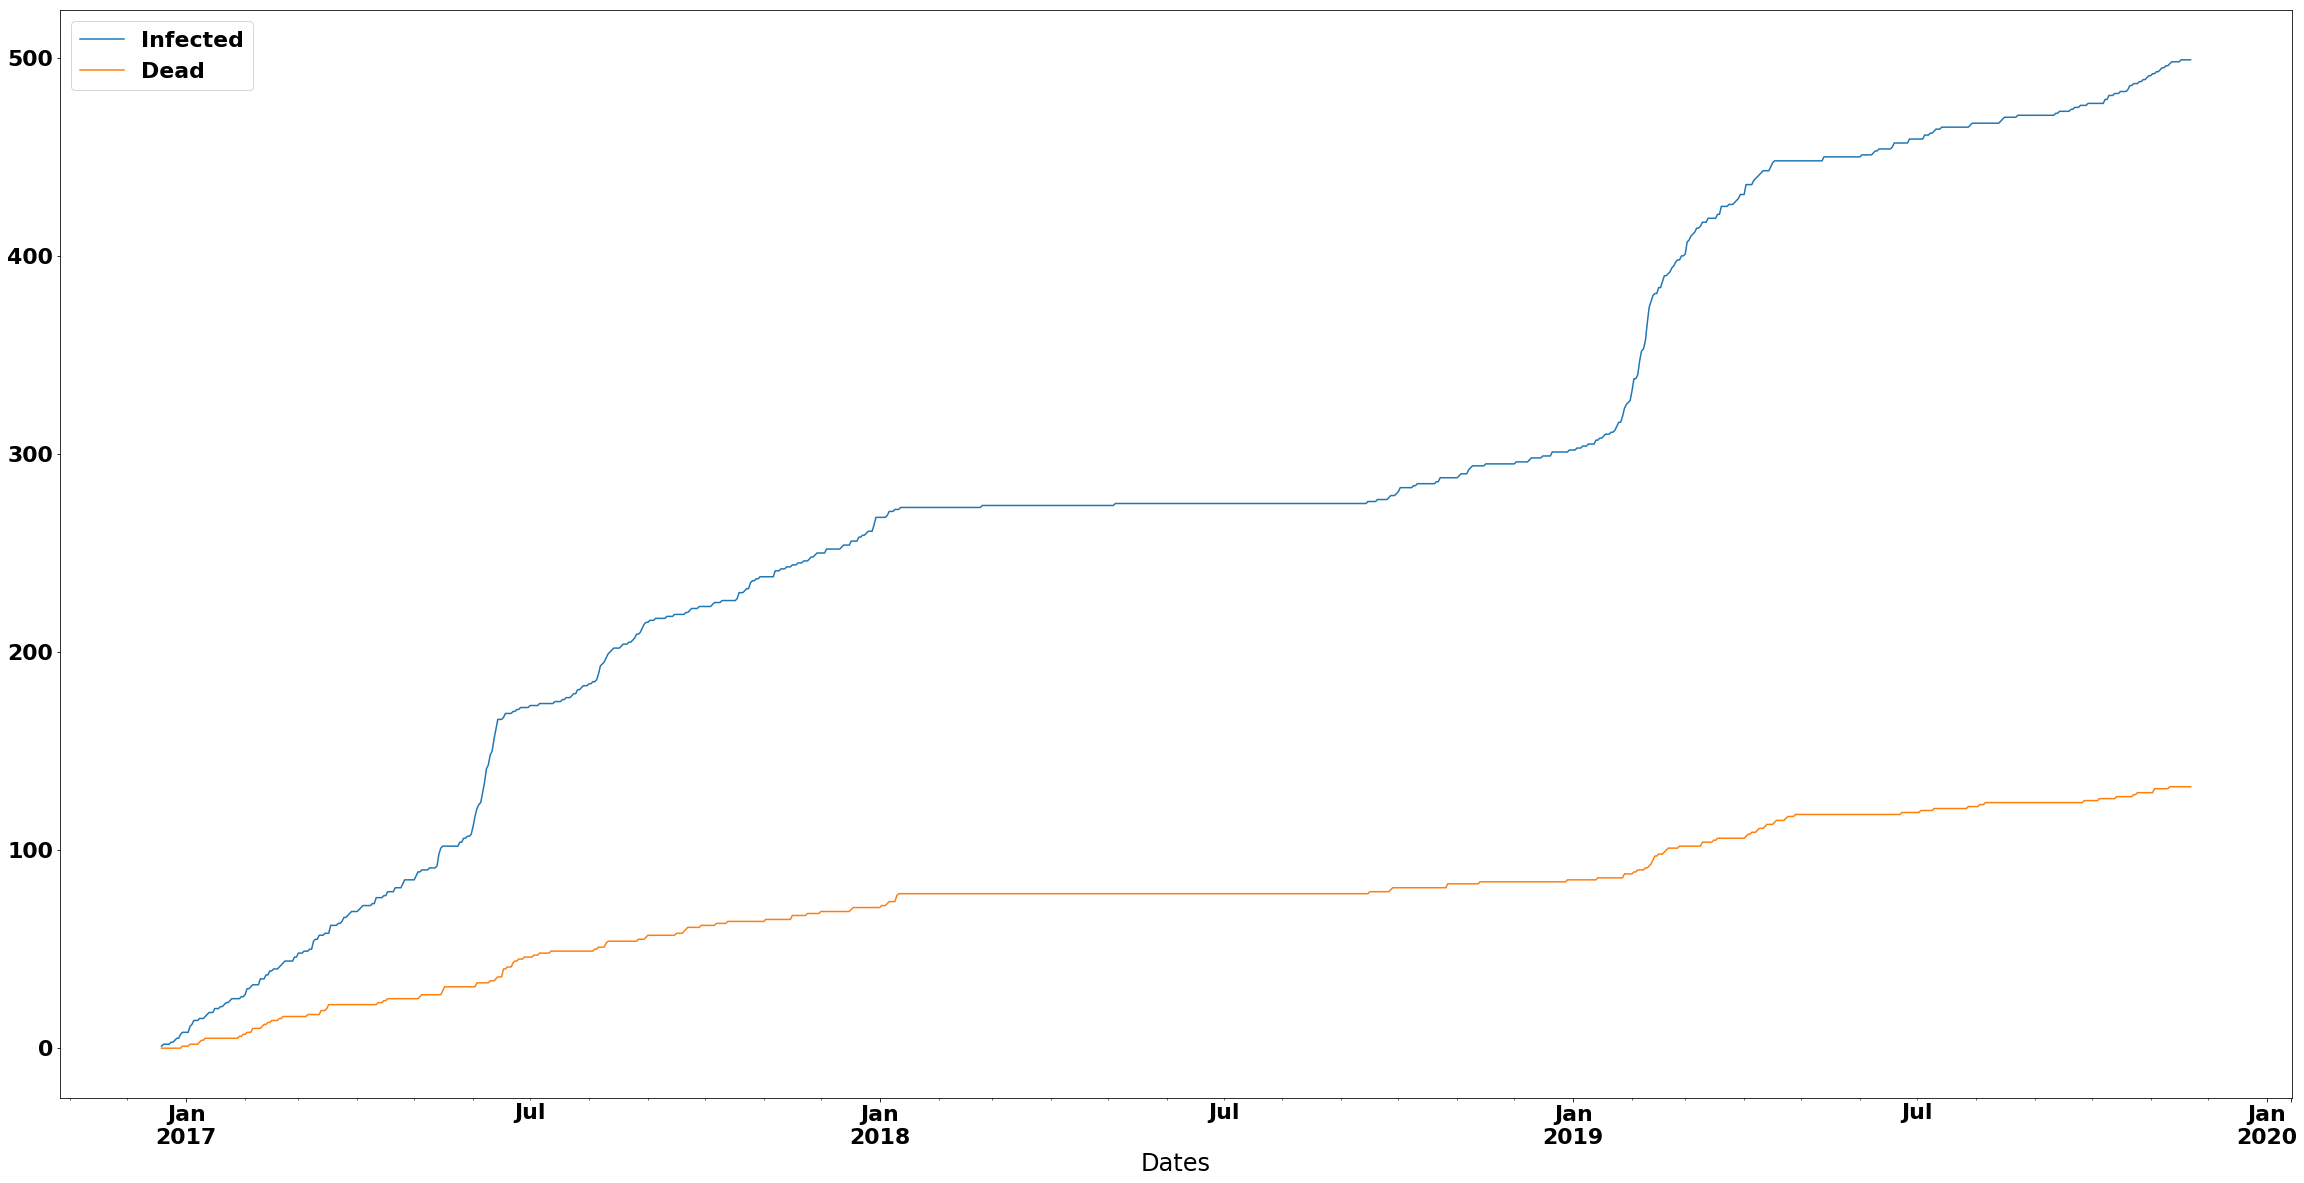

In [216]:
mers_ts.plot()

Clearly, there are two sepeare outbreaks in this dataset. One ending before week 60 (seems like week 57) and the other starting at week 90.

In [217]:
start_date = min(mers_ts.index)

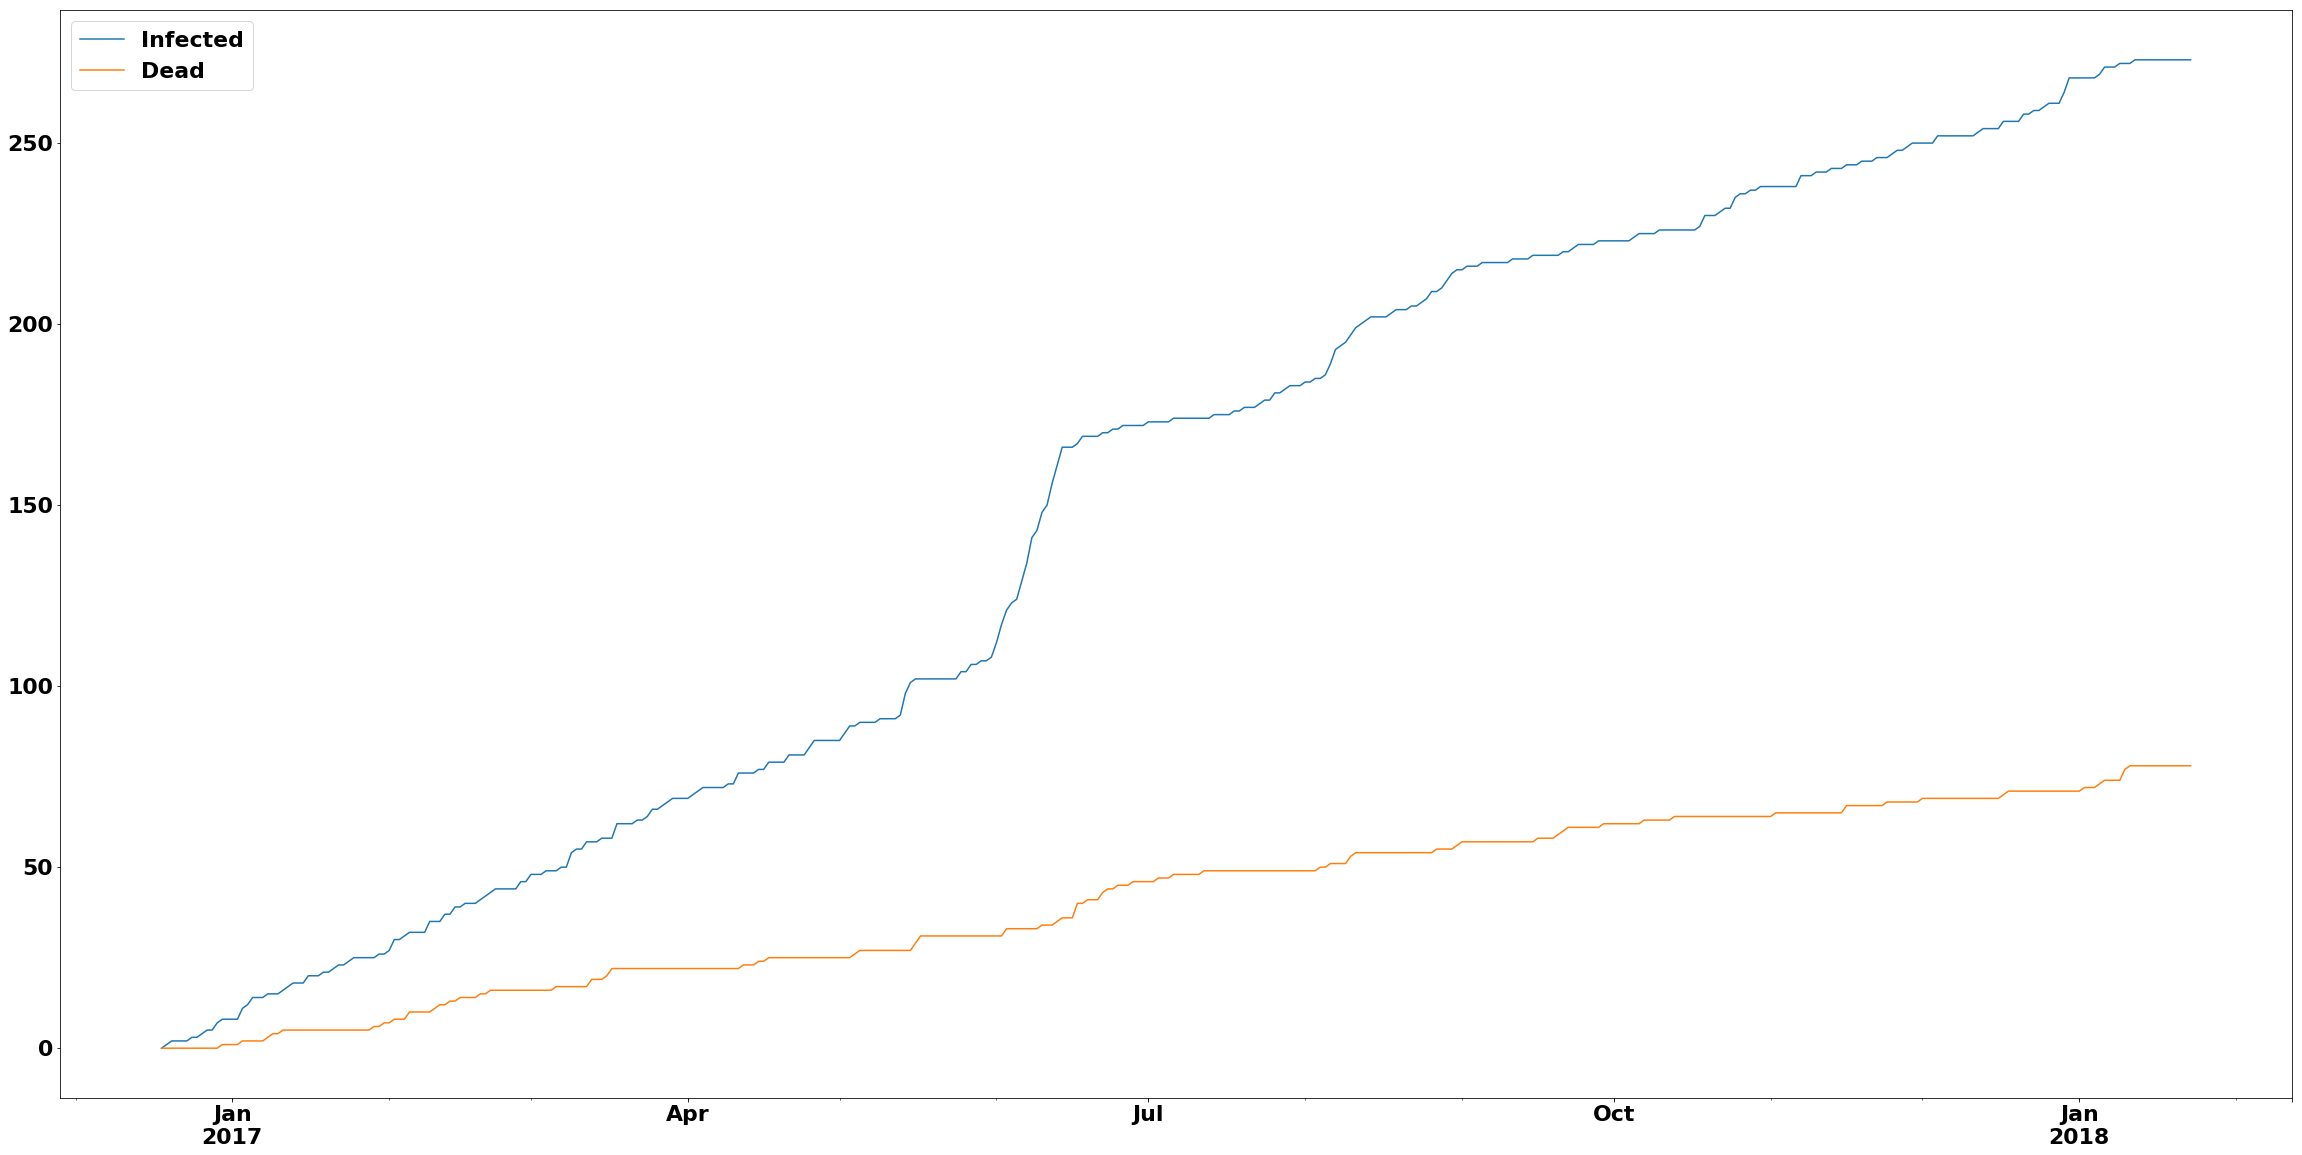

In [246]:
first_mers_ts = mers_ts.loc[:start_date + pd.Timedelta(days=400)]
# set the first day to be 0s
first_mers_ts = first_mers_ts.reindex(pd.date_range(start_date - pd.Timedelta(days=1), max(first_mers_ts.index))).fillna(0)
first_mers_ts.plot()

In [247]:
first_mers_ts.to_csv('data/time_series/cumulative/MERS_first.csv')
first_mers_ts.diff().fillna(0).to_csv('data/time_series/diff/MERS_first.csv')

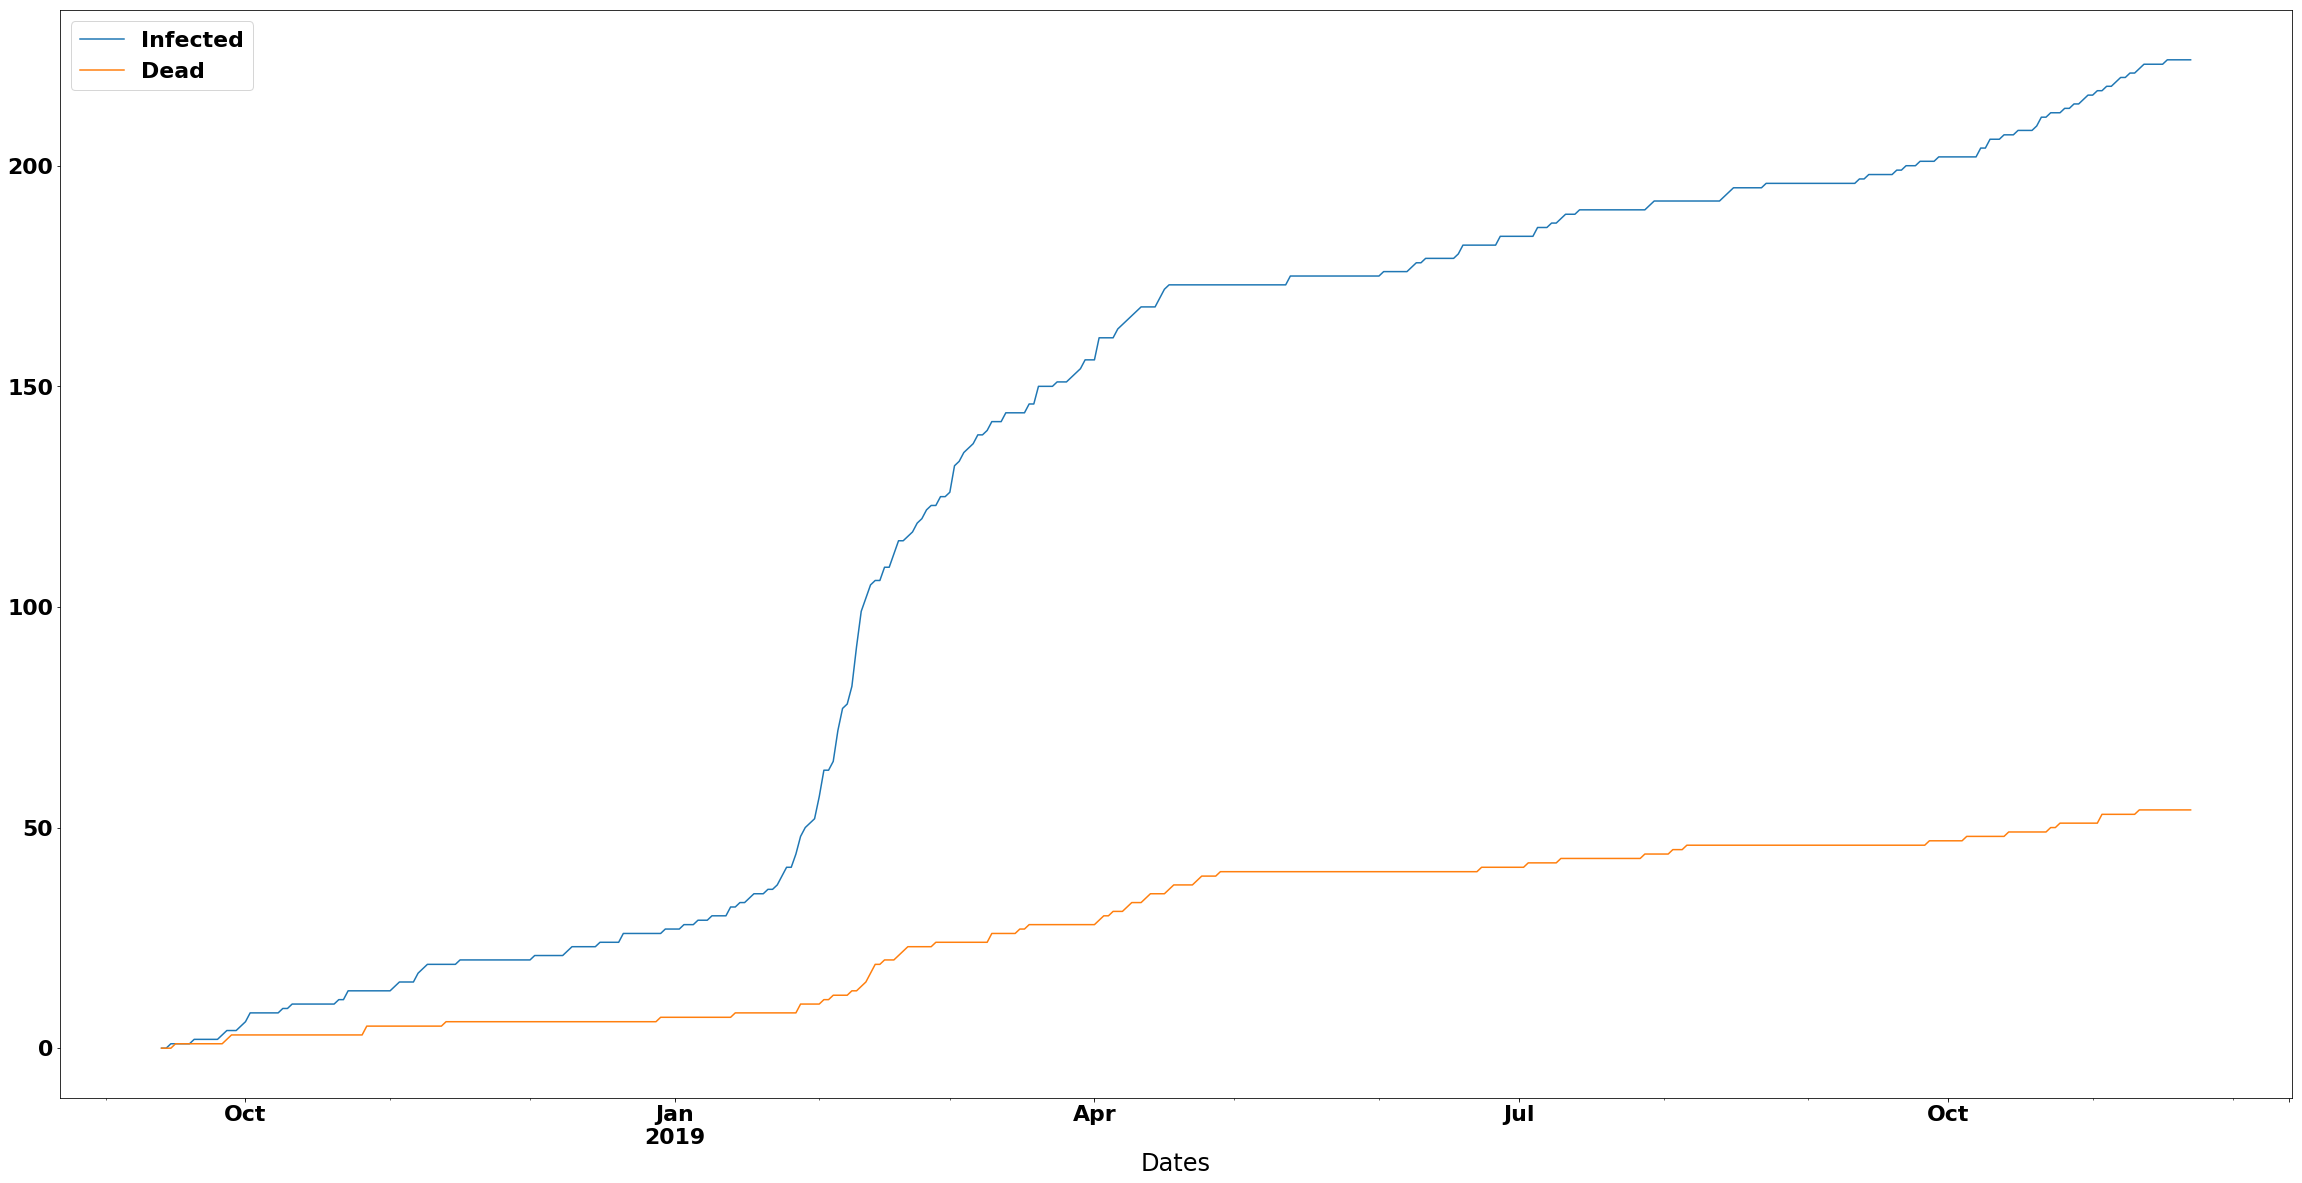

In [226]:
second_mers_ts = mers_ts.loc[start_date + pd.Timedelta(days=633):] - mers_ts.loc[start_date + pd.Timedelta(days=632)]
second_mers_ts.plot()

In [238]:
second_mers_ts.to_csv('data/time_series/cumulative/MERS_second.csv')
second_mers_ts.diff().fillna(0).to_csv('data/time_series/diff/MERS_second.csv')

## Ebola

The dataset was obtained from https://data.humdata.org/dataset/ebola-cases-2014 and the WHO is the source. There are a couple of caveats:

> The WHO declared Senegal, Nigeria, Spain, United States of America, Mali, the United Kingdom, Liberia, Sierra Leone and Guinea to be Ebola free on 17 October, 20 October, 2 December, mid December 2014, 18 January 2015, 10 March 2015, 9 May 2015, 7 November 2015 and 29 December 2015 respectively. Although not reported in the sitrep, the cumulative figures from these countries are presented in the dataset for convenience. On 14 November 2014, Liberia has fewer deaths than the last update on 12 November due to reclassification. Data are based on official information reported by ministries of health, through WHO country offices. 

In [87]:
eradication_dates = {
    'Senegal': '2014-10-17',
    'Nigeria': '2014-10-20',
    'Spain': '2014-12-02',
    'United States of America': '2014-12-15',
    'Mali': '2015-01-18',
    'United Kingdom': '2015-03-10',
    'Liberia': '2015-05-09',
    'Sierra Leone': '2015-11-07',
    'Guinea': '2015-12-29',
}

ebola_df = pd.read_csv('../data/raw/ebola_data_db_format.csv', parse_dates=["Date"])

Notice that the `"Indicator"` column provides us with the context of the value for a given row. Although it initially seemed to be a simple enough distribution of values, as can be seen below, there are a lot of indicators available.

In [91]:
confirmed_df = ebola_df[ebola_df["Indicator"].isin(["Cumulative number of confirmed Ebola cases", "Cumulative number of confirmed Ebola deaths"])]

In [92]:
confirmed_df[confirmed_df["Country"] == "Liberia"].sort_values(by="Date")

,Indicator,Country,Date,value
5090,Cumulative number of confirmed Ebola cases,Liberia,2014-08-29,322.0
5138,Cumulative number of confirmed Ebola deaths,Liberia,2014-08-29,225.0
5018,Cumulative number of confirmed Ebola deaths,Liberia,2014-09-05,431.0
4964,Cumulative number of confirmed Ebola cases,Liberia,2014-09-05,614.0
4850,Cumulative number of confirmed Ebola cases,Liberia,2014-09-08,634.0
...,...,...,...,...
17230,Cumulative number of confirmed Ebola cases,Liberia,2015-12-17,3151.0
17298,Cumulative number of confirmed Ebola cases,Liberia,2015-12-22,3151.0
17359,Cumulative number of confirmed Ebola cases,Liberia,2015-12-23,3151.0
17432,Cumulative number of confirmed Ebola cases,Liberia,2015-12-29,3151.0


In [93]:
reduced_df = confirmed_df.groupby(['Country', 'Date', 'Indicator'])['value'].sum().unstack('Indicator').fillna(method='ffill').astype('int64')

There are a few countries in the dataset that had only a handful of confirmed cases. We will disregard them as they don't represent the true outbreaks. We will therefore only keep Guinea, Liberia and Sierra Leone.

In [94]:
reduced_df.max(level=0)

Indicator,Cumulative number of confirmed Ebola cases,Cumulative number of confirmed Ebola deaths
Country,,
Guinea,3351,2083
Guinea 2,2,1
Italy,1,1
Liberia,3153,3858
Liberia 2,9,3
Mali,7,5
Nigeria,19,7
Senegal,1,0
Sierra Leone,8704,3589


In [95]:
reduced_df = reduced_df.loc[['Guinea', 'Liberia', 'Sierra Leone']].rename({
    "Cumulative number of confirmed Ebola cases": 'Infected',
    "Cumulative number of confirmed Ebola deaths": 'Dead'
}, axis=1)

In [96]:
guinea_df = reduced_df.loc['Guinea'][:eradication_dates['Guinea']]
liberia_df = reduced_df.loc['Liberia'][:eradication_dates['Liberia']]
sierra_leone_df = reduced_df.loc['Sierra Leone'][:eradication_dates['Sierra Leone']]

### Guinea

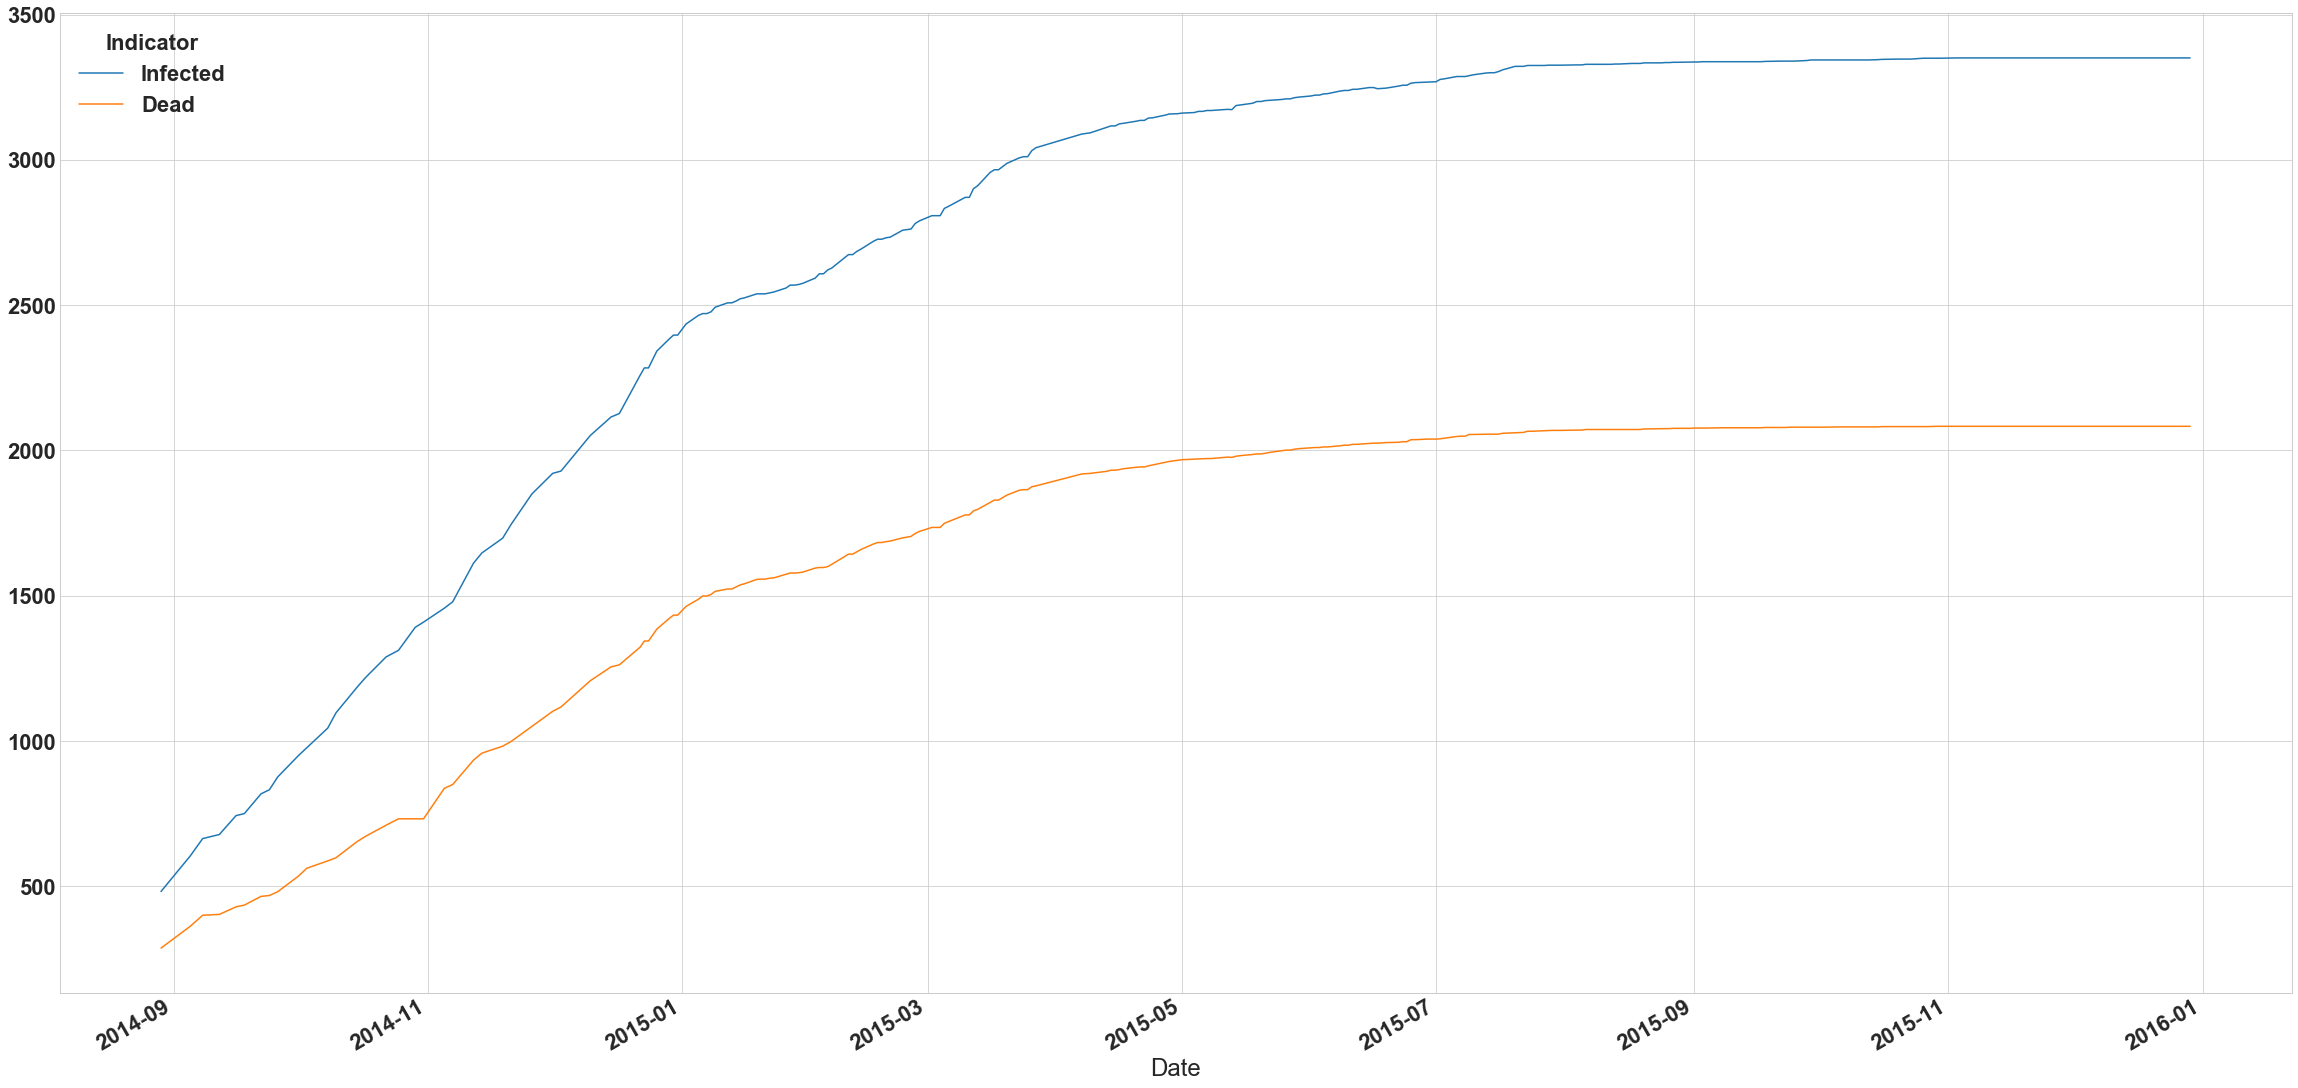

In [97]:
guinea_df.plot()

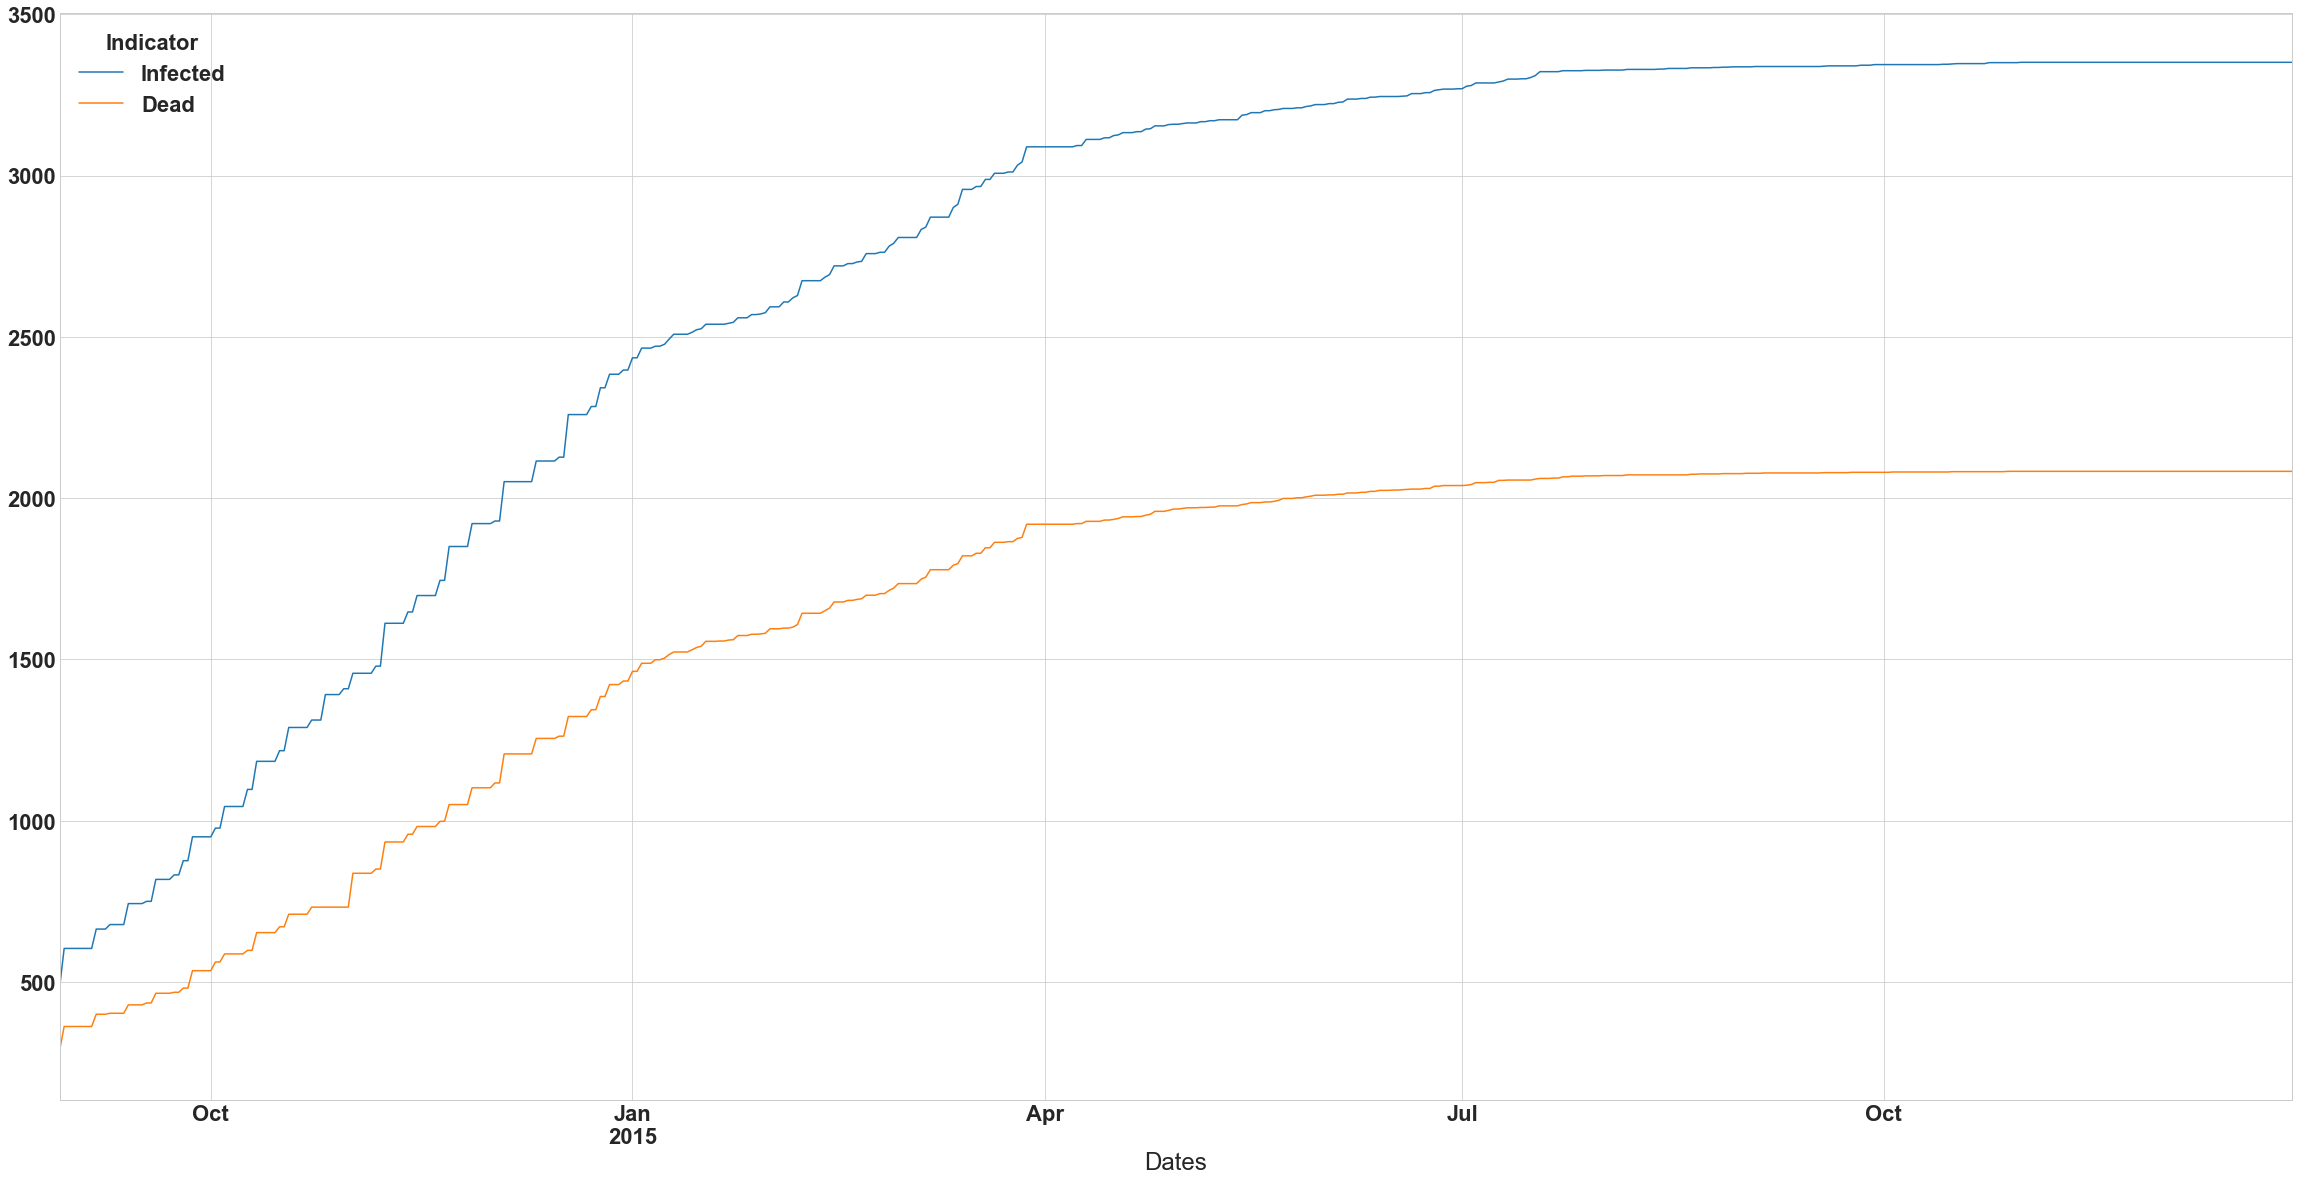

In [99]:
clean_guinea_df = normalize_date_index(consider_reclassifications(guinea_df))

clean_guinea_df.plot()

In [106]:
clean_guinea_df.to_csv("../data/time_series/cumulative/ebola_guinea.csv")
clean_guinea_df.diff().fillna(0).to_csv("../data/time_series/diff/ebola_guinea.csv")

### Sierra Leone

There are some inconsistencies for the Sierra Leone data with respect to the evolution of confirmed deaths (most likely due to reclassifications of the cases). For this reason, we will consider the reclassifications and store it to be processed.

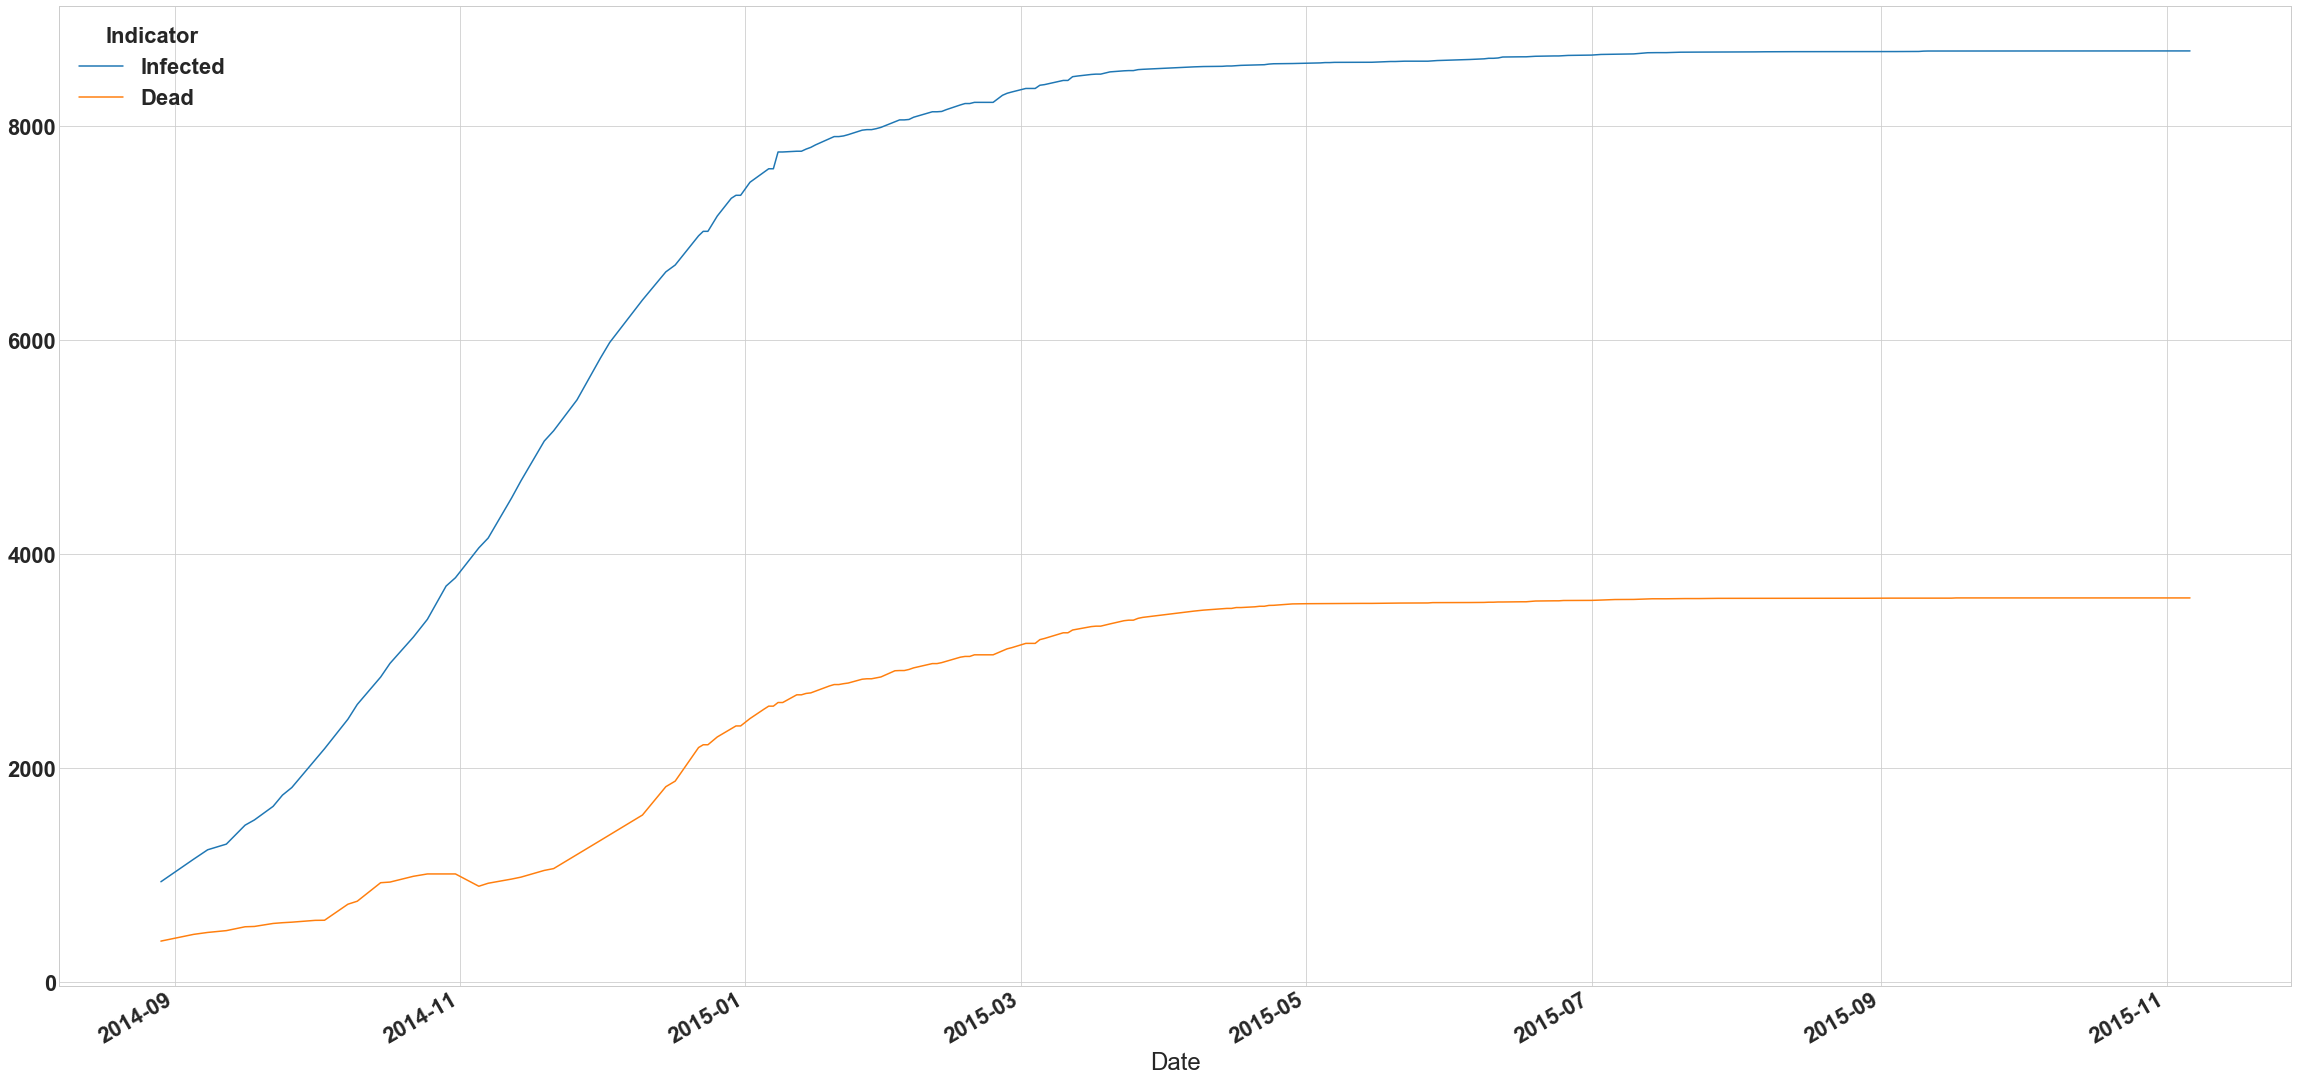

In [101]:
sierra_leone_df.plot()

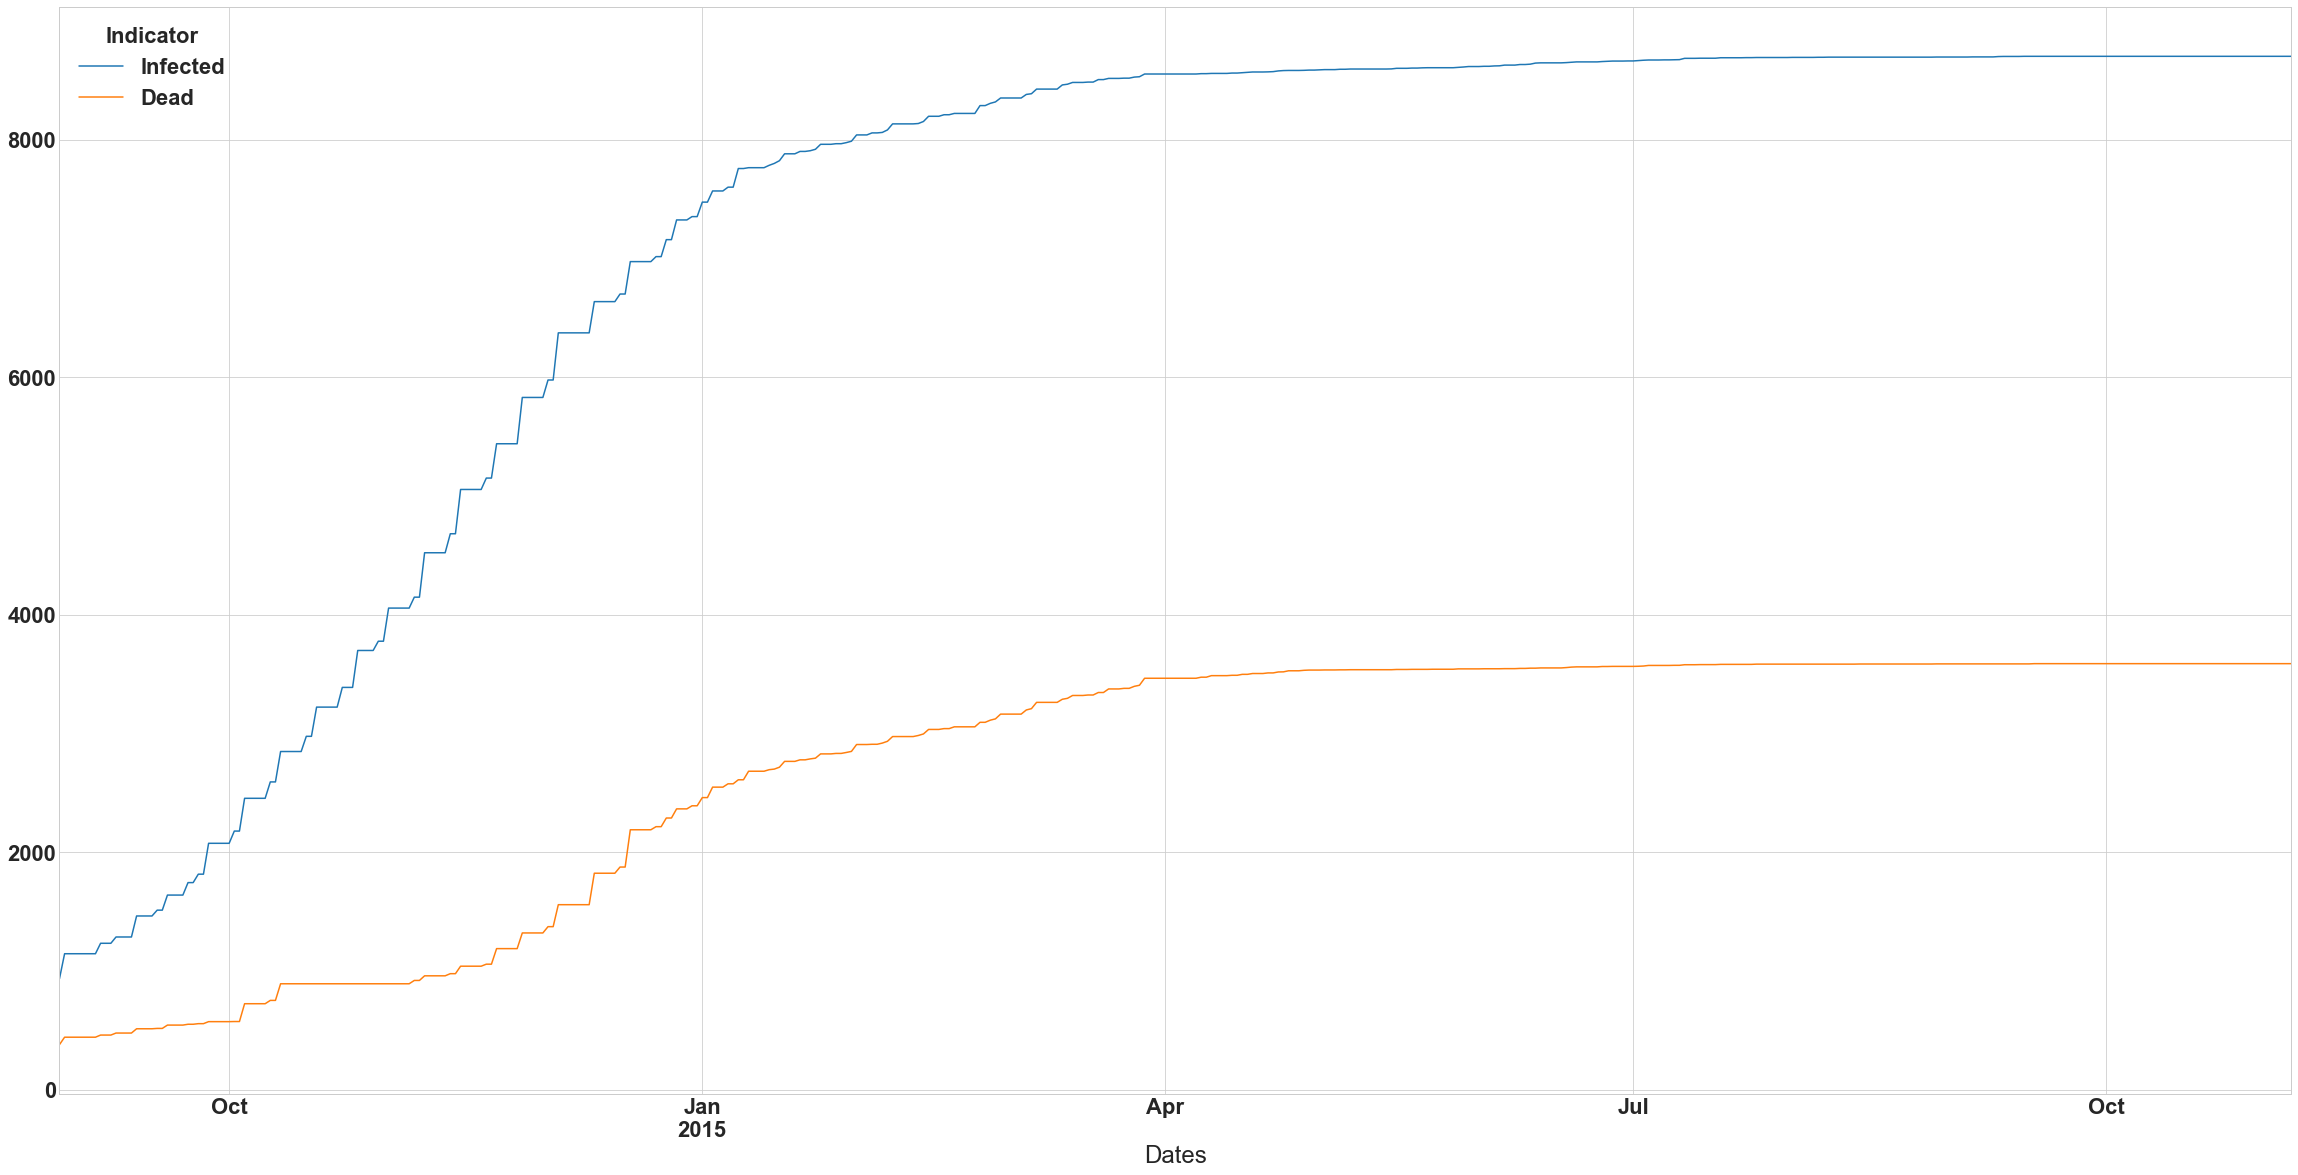

In [102]:
clean_sierra_leone_df = normalize_date_index(consider_reclassifications(sierra_leone_df))

clean_sierra_leone_df.plot()

In [103]:
clean_sierra_leone_df.to_csv("../data/time_series/cumulative/ebola_sierra_leone.csv")
clean_sierra_leone_df.diff().fillna(0).to_csv("../data/time_series/diff/ebola_sierra_leone.csv")

### Liberia

The Liberia dataset makes no sense so it will not be considered

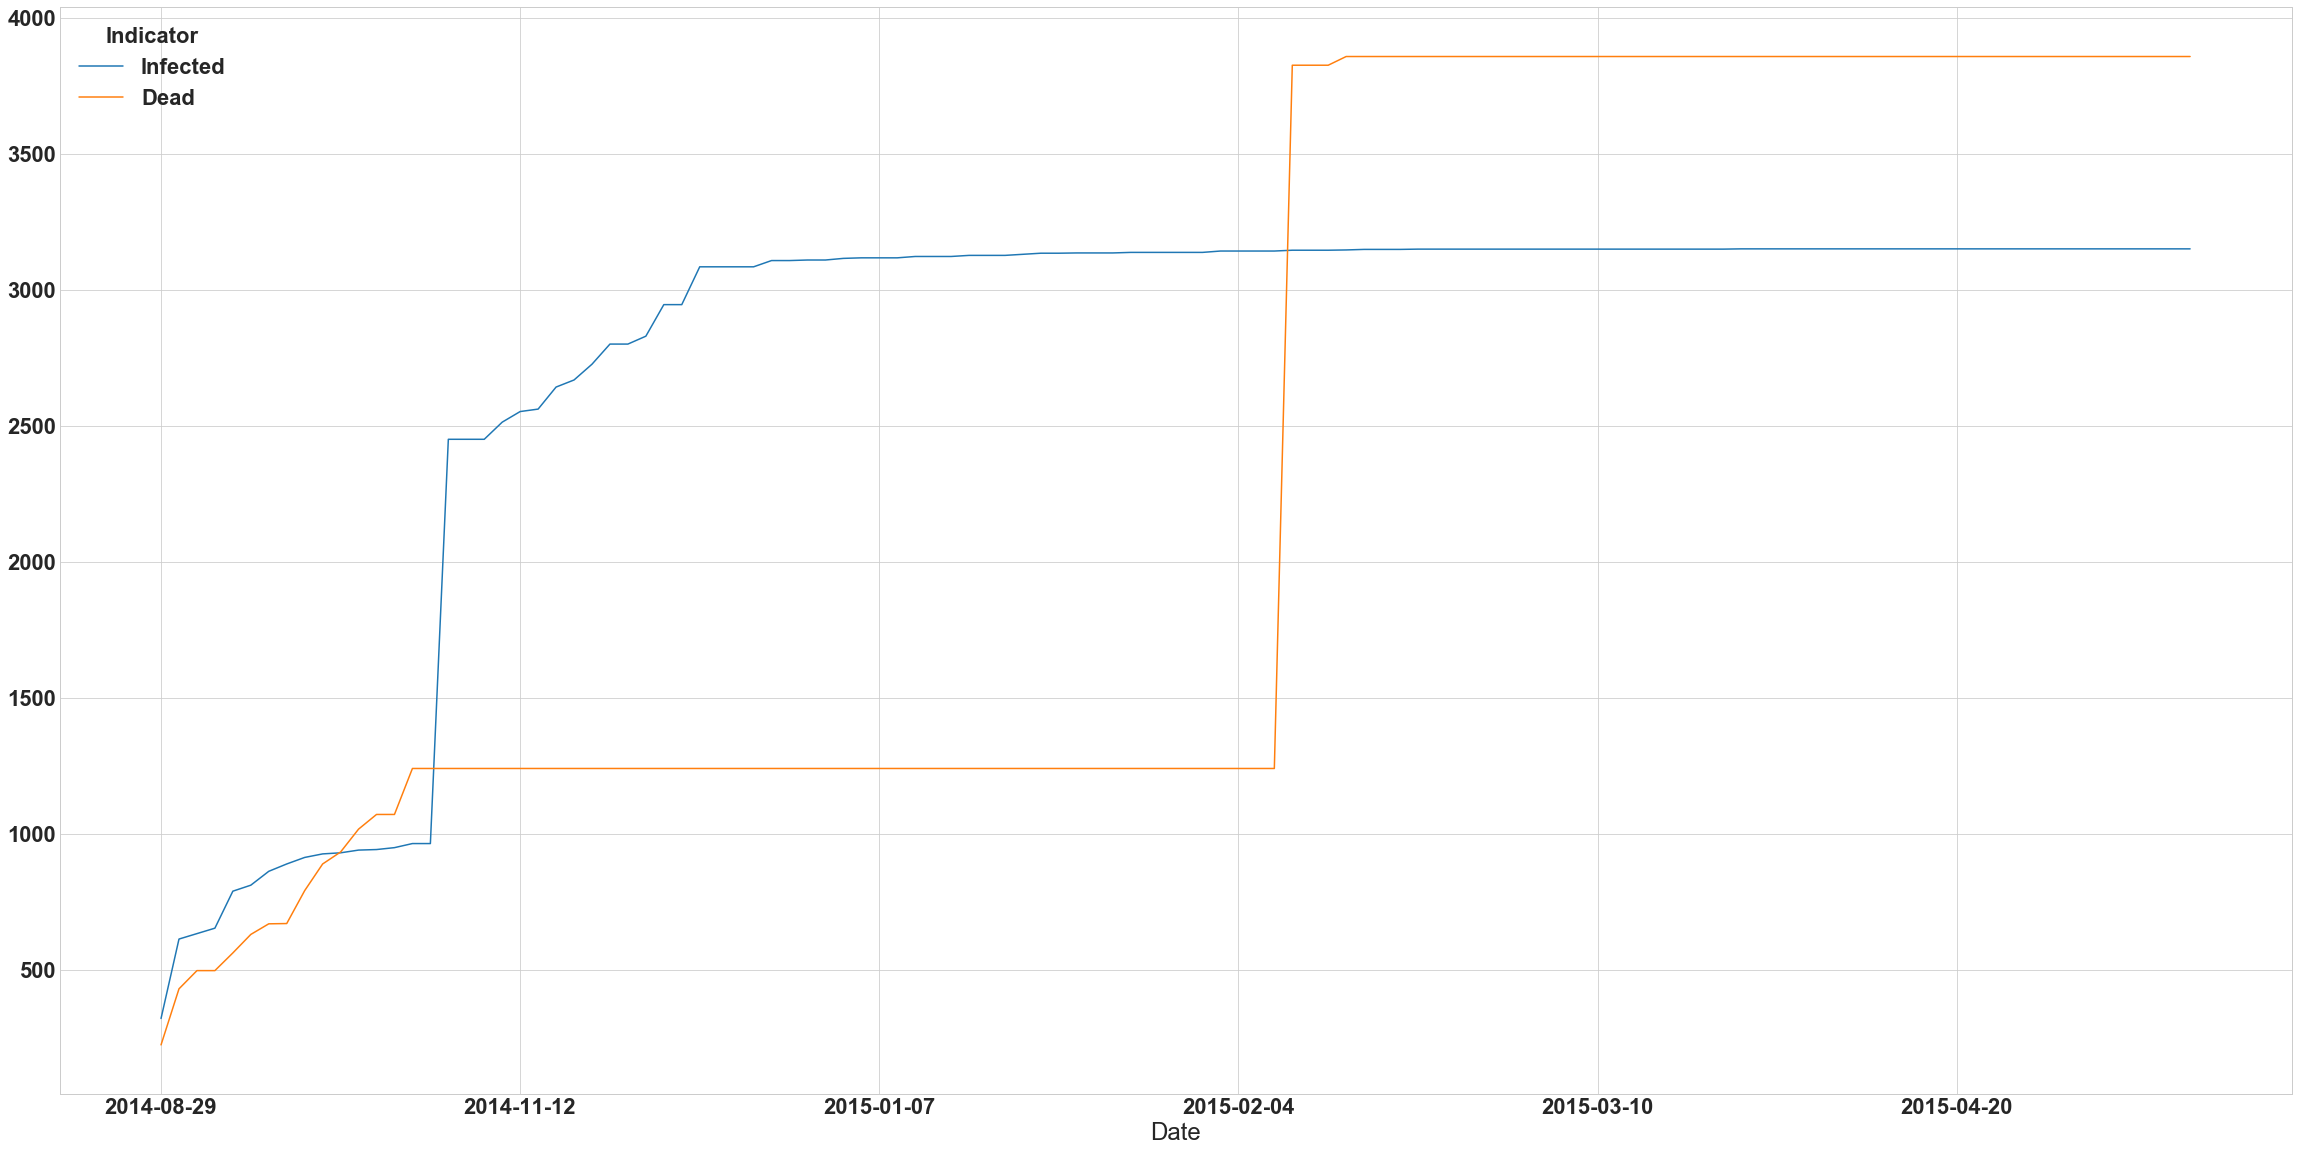

In [75]:
consider_reclassifications(liberia_df).plot()

In [60]:
guinea_df.to_csv('data/time_series/ebola_guinea.csv')
liberia_df.to_csv('data/time_series/ebola_liberia.csv')
sierra_leone_df.to_csv('data/time_series/ebola_sierra_leone.csv')

## Coronavirus

The timeseries datasets for the Novel Coronavirus were provided by JHU CSSE (John's Hopkins) in this [GitHub repo](https://github.com/CSSEGISandData/COVID-19/).

### Global

In [80]:
global_confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
global_death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

In [81]:
global_confirmed_df = global_confirmed_df.drop(["Lat", "Long", "Province/State"], axis=1).groupby('Country/Region').sum().transpose()
global_death_df = global_death_df.drop(["Lat", "Long", "Province/State"], axis=1).groupby('Country/Region').sum().transpose()

In [124]:
def get_top_regions(df):
    return df.iloc[-1].sort_values(ascending=False).index.tolist()

In [158]:
top_n = 10

In [159]:
top_confirmed_regions = get_top_regions(global_confirmed_df)[:top_n]
top_death_regions = get_top_regions(global_death_df)[:top_n]

### Top 10 Countries Affected

In [160]:
top_confirmed_ma = global_confirmed_df[top_confirmed_regions].rolling(3).mean()

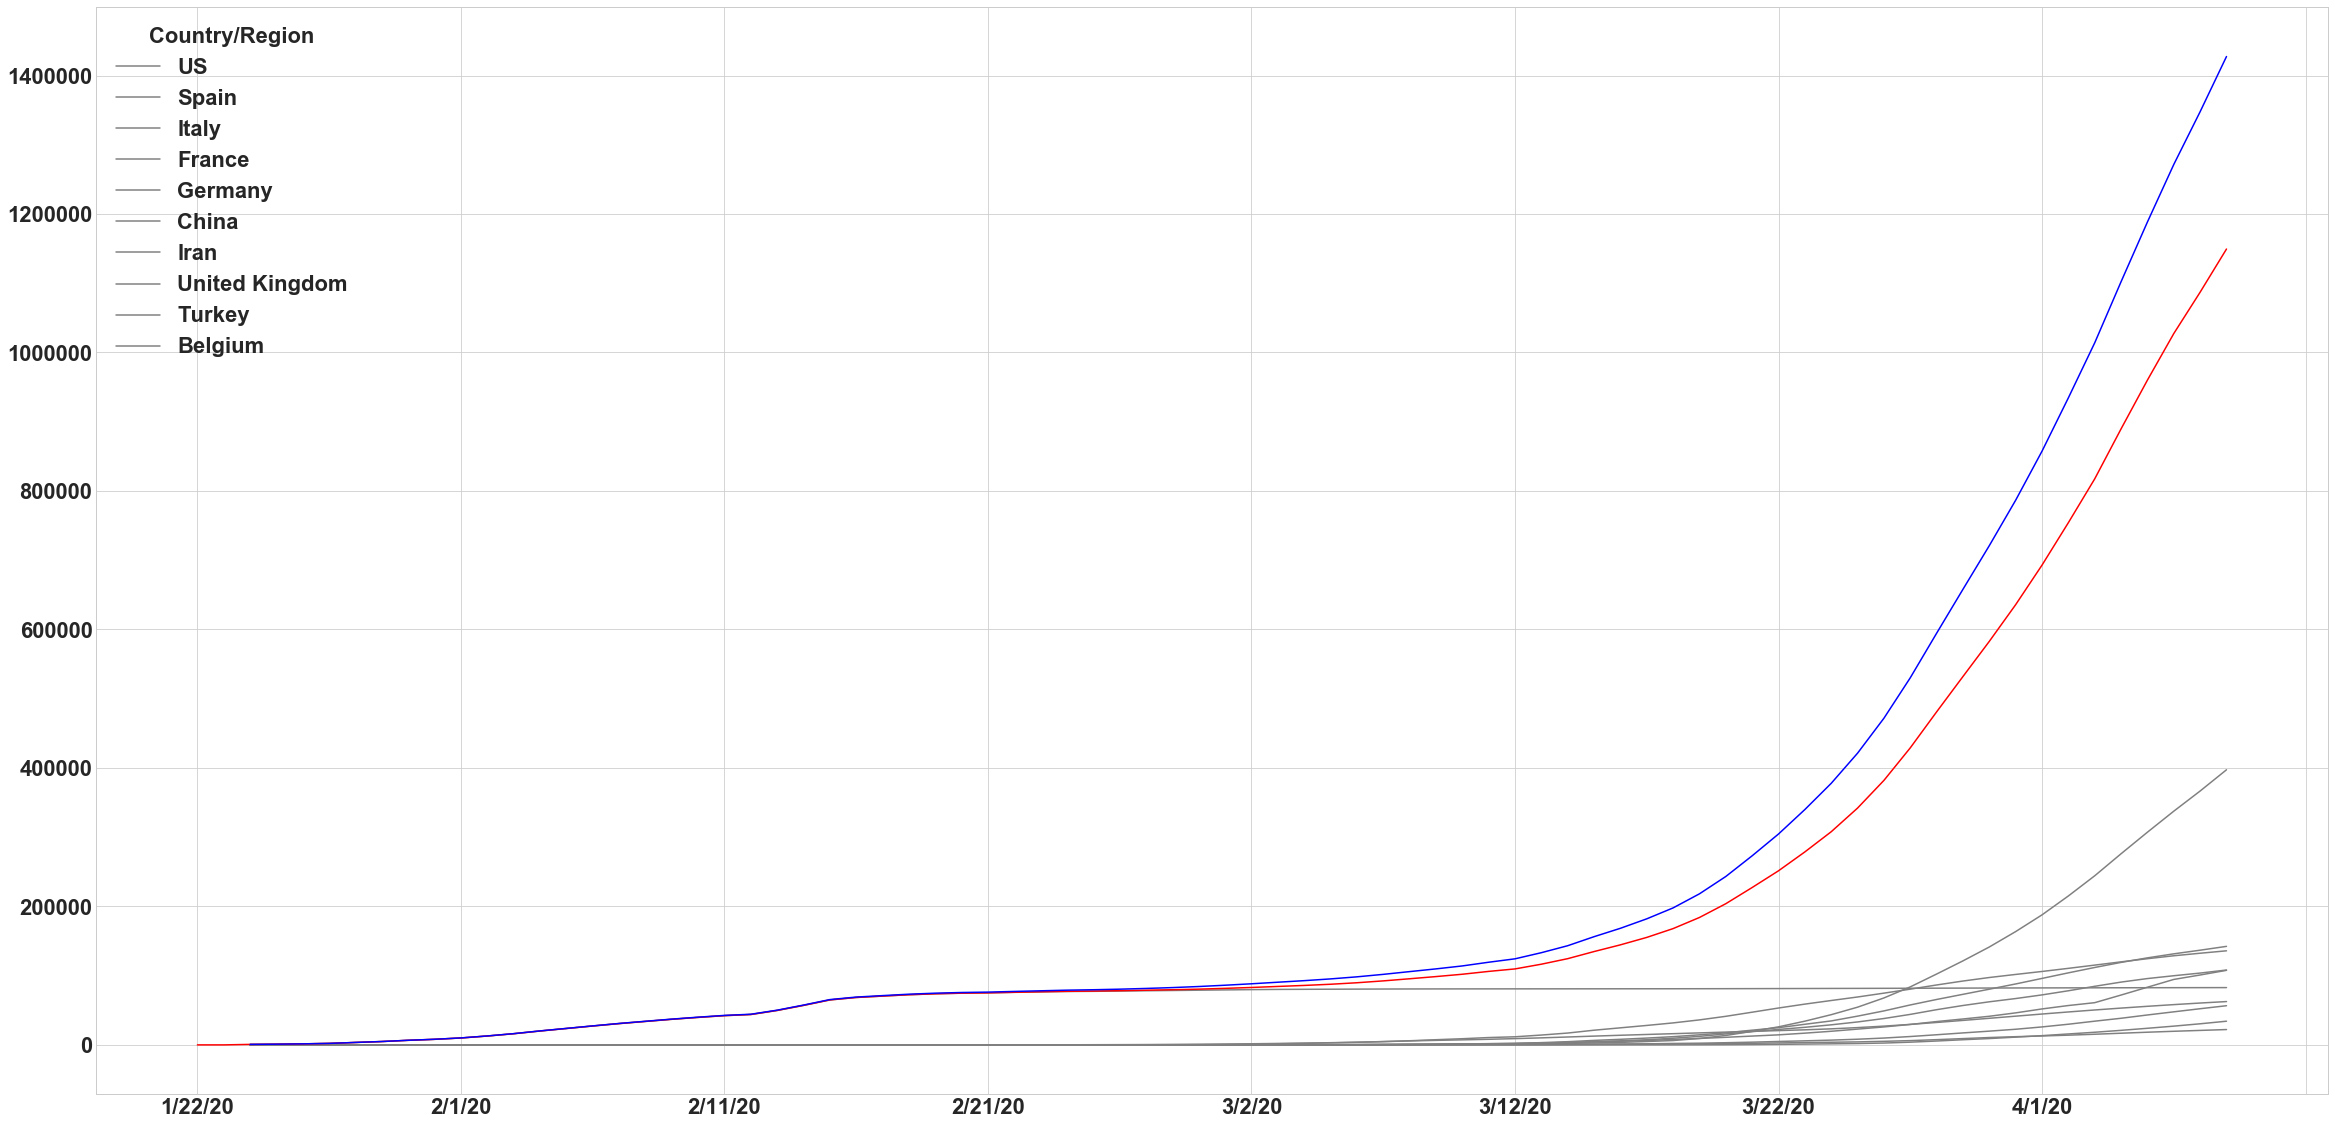

In [157]:
fig, ax = plt.subplots()

fig.set_title('Confirmed Cases')

top_confirmed_ma.plot(ax=ax, c='grey')
top_confirmed_ma.sum(axis=1).plot(ax=ax, c='r', label=f'Total Confirmed Cases (Top {top_n} Regions)')
global_confirmed_df.sum(axis=1).rolling(3).mean().plot(ax=ax, c='b', label=f'Total Confirmed Cases')

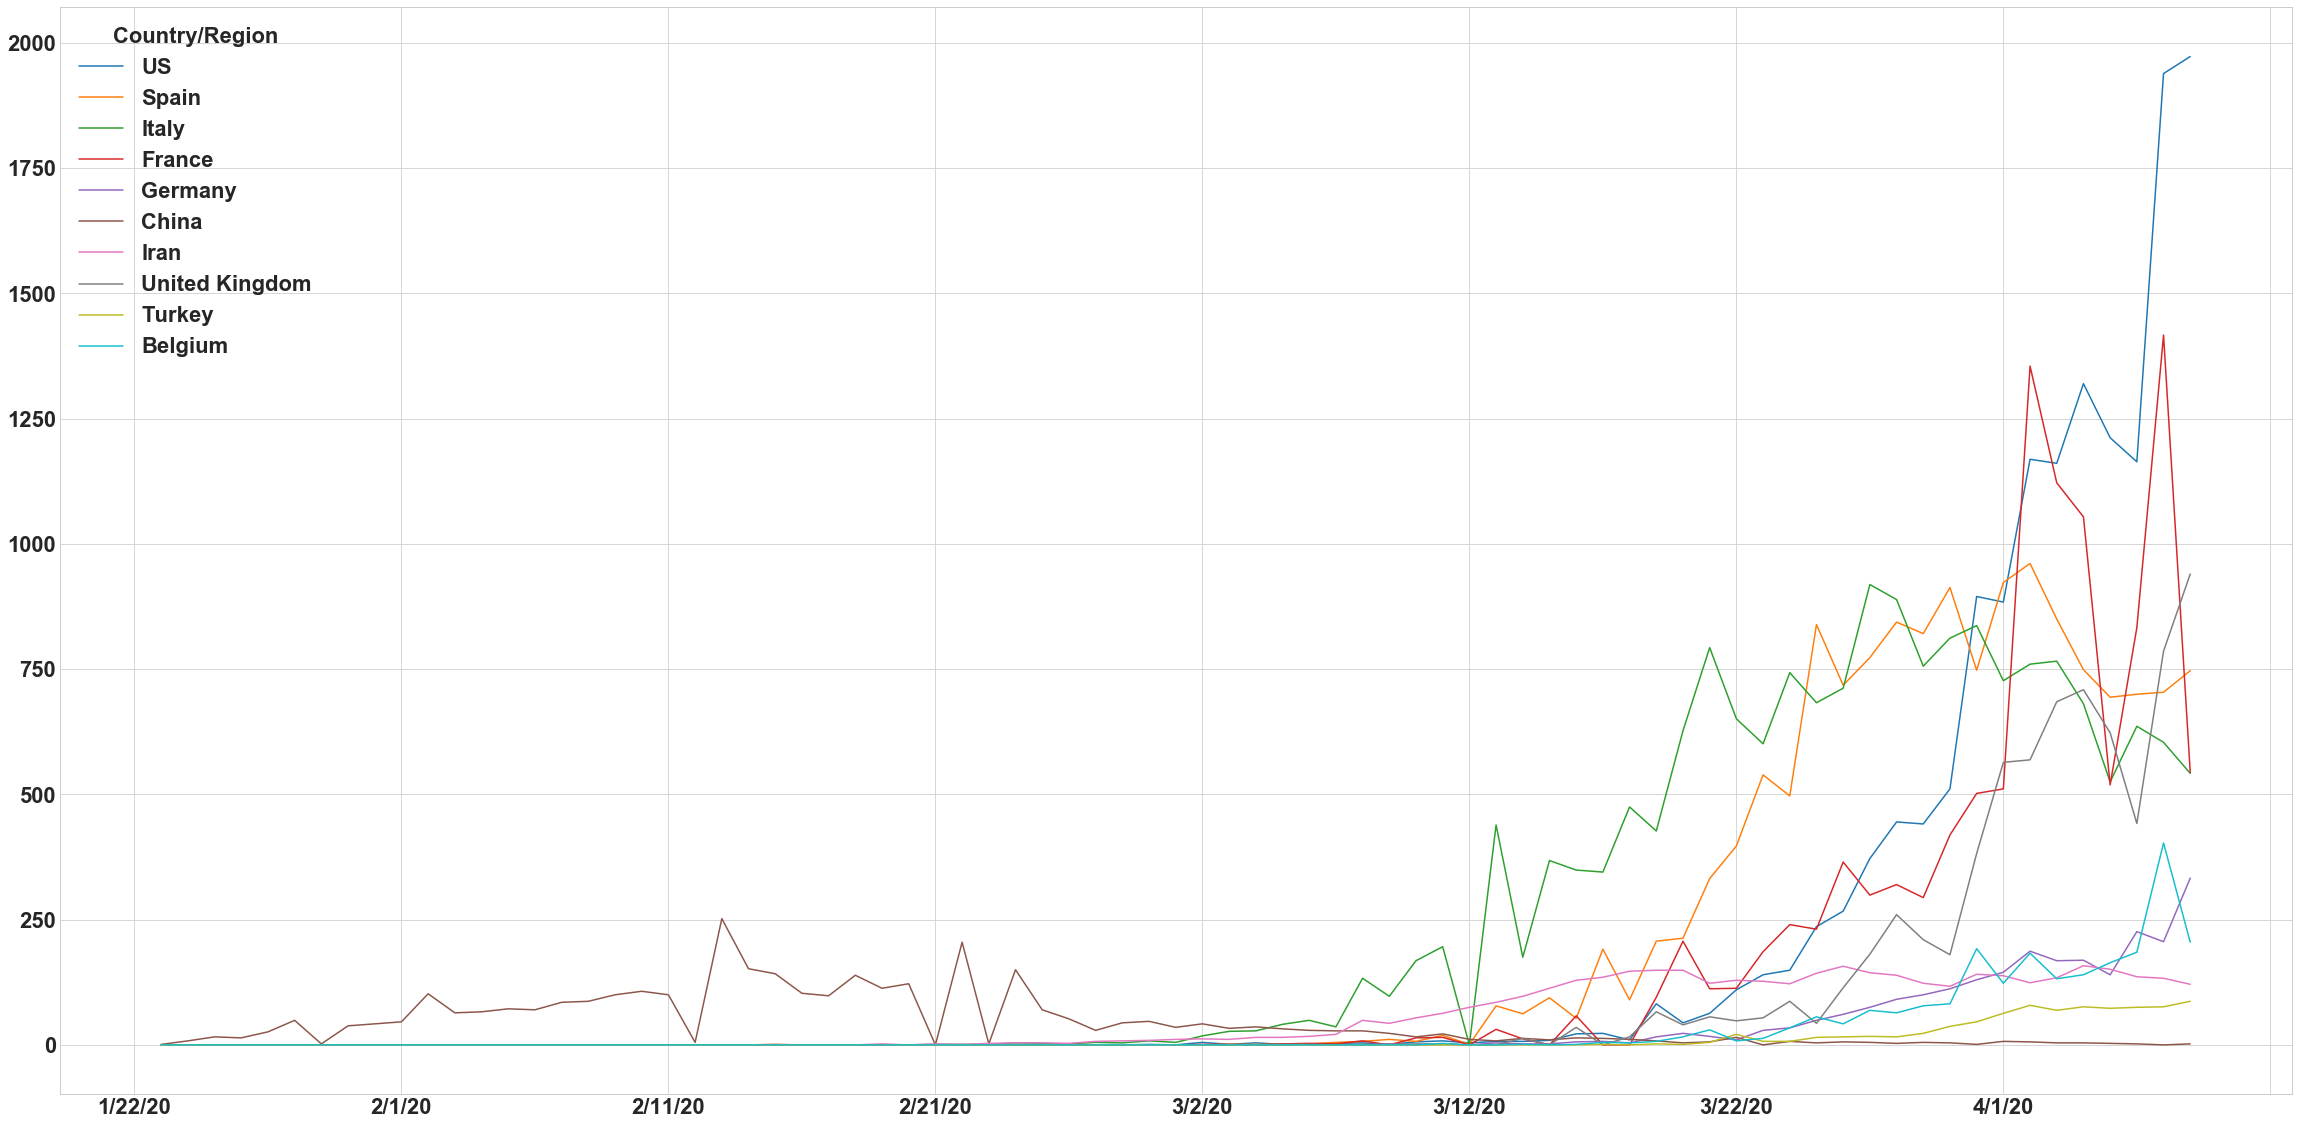

In [144]:
global_death_df[top_confirmed_regions].diff().plot()

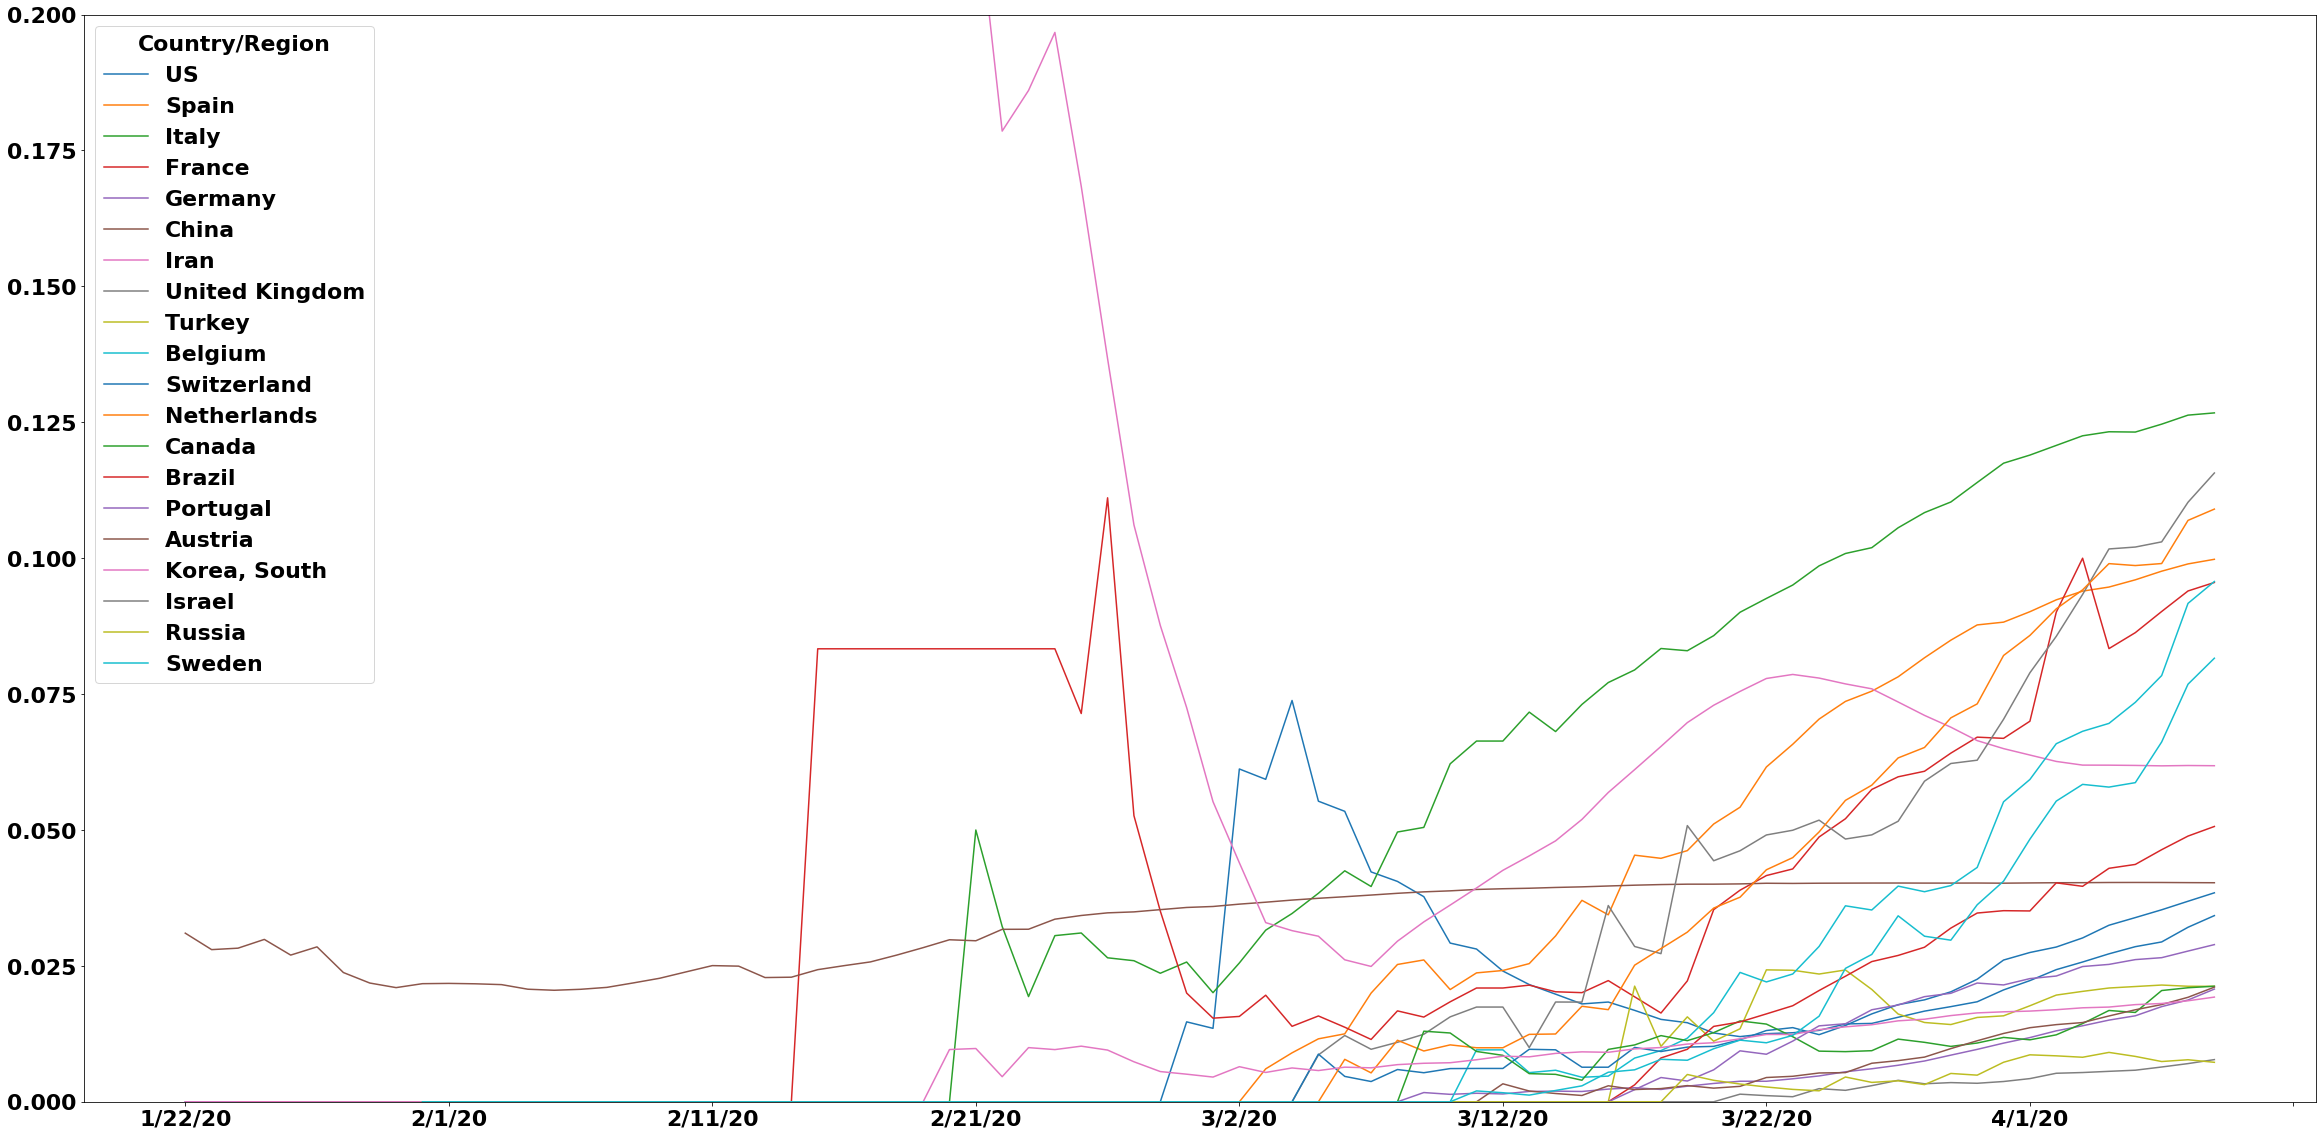

In [131]:
axes = plt.gca()
axes.set_ylim([0, 0.2])
(global_death_df / global_confirmed_df)[top_confirmed_regions].plot(ax=axes)
plt.show()

### US

In [116]:
us_confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv') 
us_death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')

Now that they are loaded, we drop the extraneous columns, groupby regions and sum them in order to get region-granular curves.

In [117]:
us_confirmed_df = us_confirmed_df.drop(["UID", "iso2", "iso3", "code3", "Admin2", "Lat", "Long_", "FIPS", "Country_Region", "Combined_Key"], axis=1).groupby('Province_State').sum().transpose()
us_death_df = us_death_df.drop(["UID", "iso2", "iso3", "code3", "Admin2", "Lat", "Long_", "FIPS", "Country_Region", "Combined_Key"], axis=1).groupby('Province_State').sum().transpose()

In [118]:
assert (us_confirmed_df.columns == us_death_df.columns).all()

We should remove those regions not yet affected by the epidemic.

In [70]:
no_case_mask = us_confirmed_df.eq(0).all()

us_confirmed_df = us_confirmed_df.loc[:, ~no_case_mask]
us_death_df = us_death_df.loc[:, ~no_case_mask]

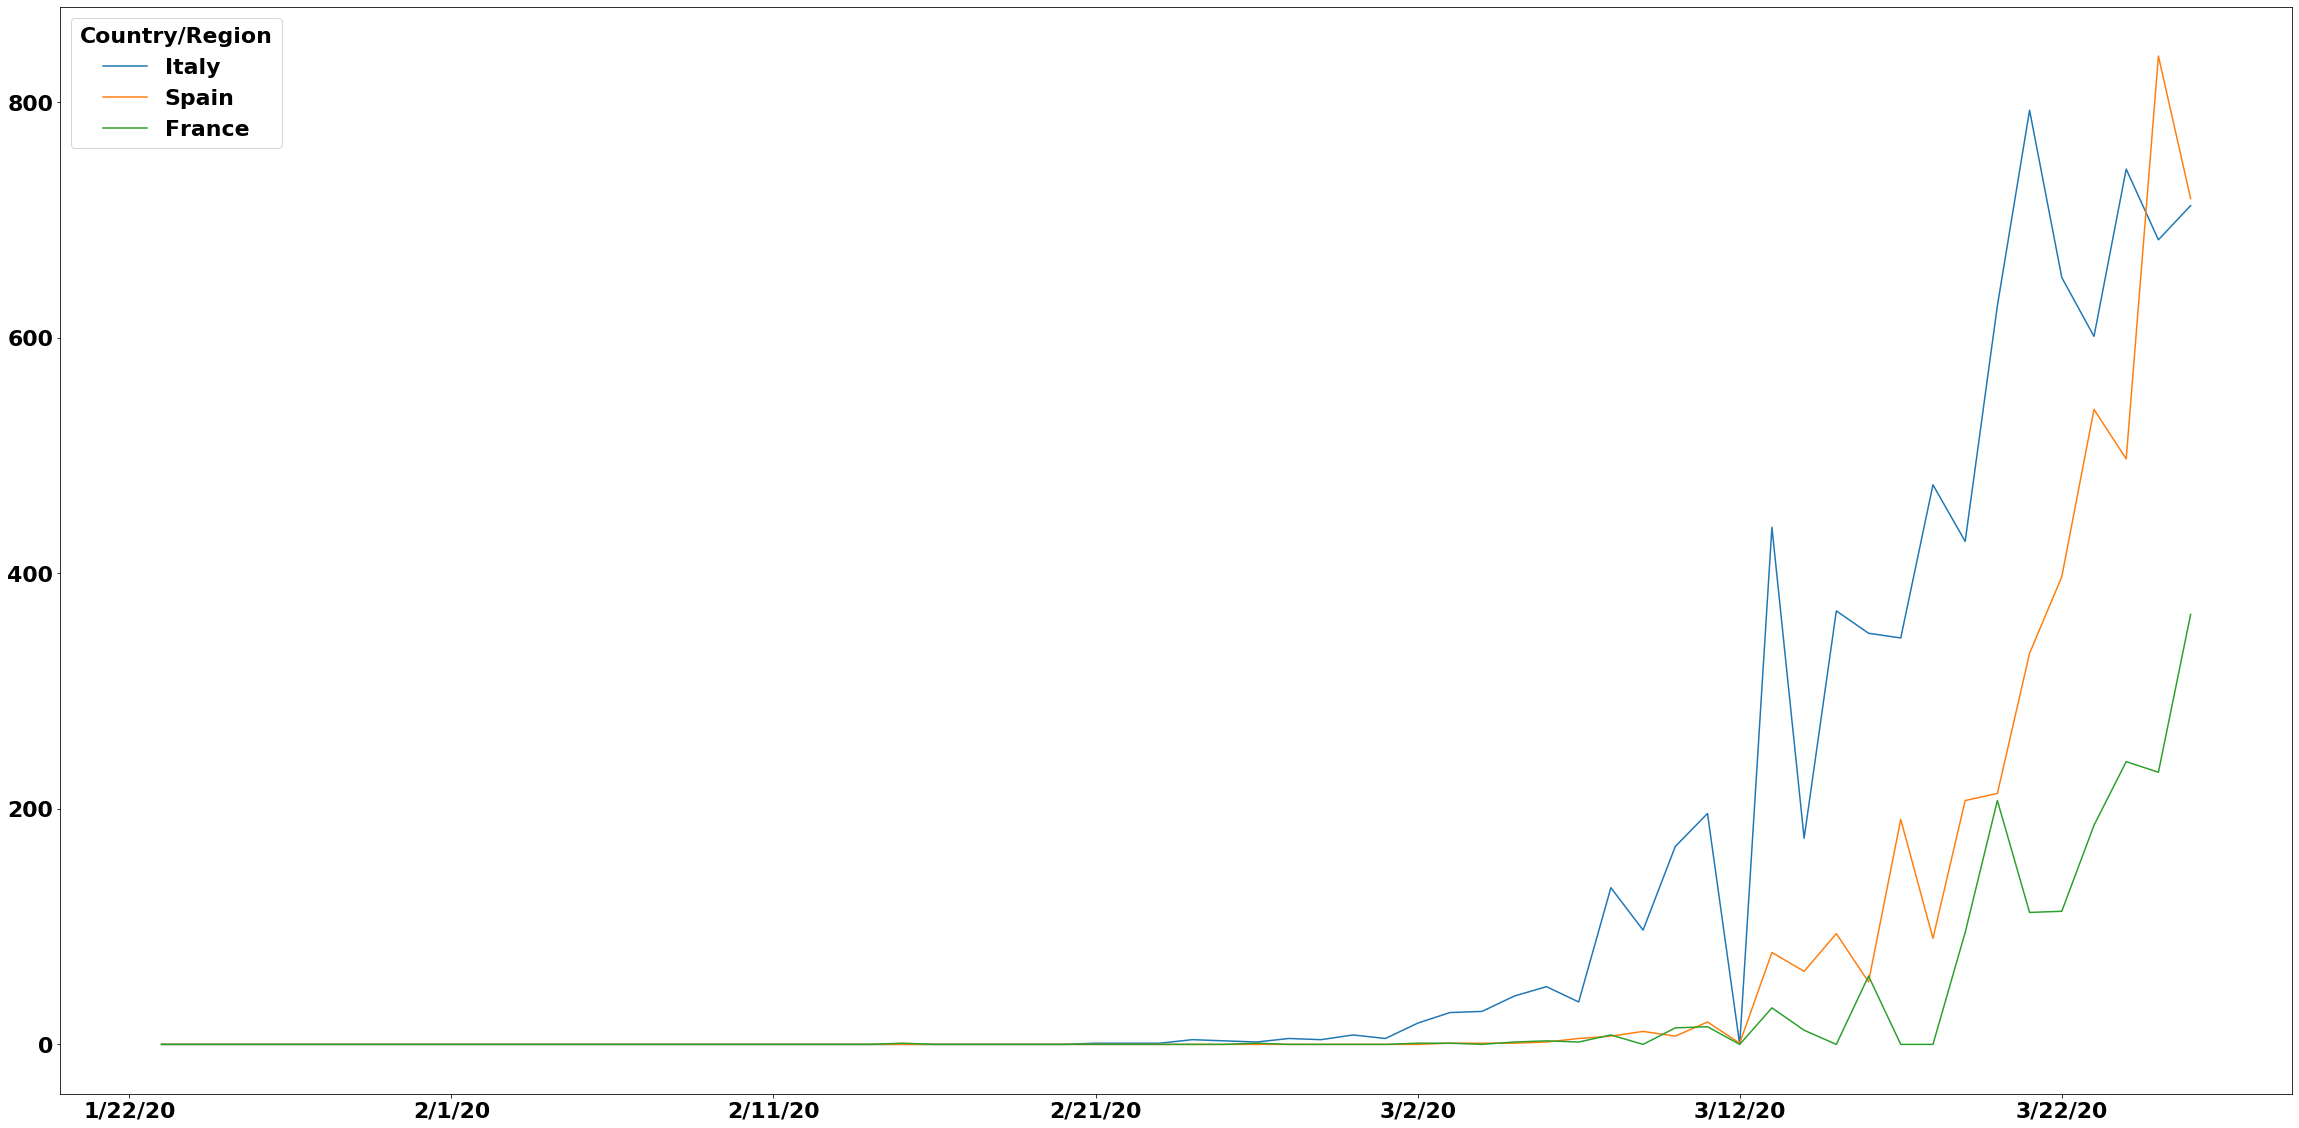

In [42]:
df.transpose()[["Italy", "Spain", "France"]].diff().plot()

In [2]:
coronavirus_infected = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')\
                      .drop(["Province/State", "Country/Region", "Lat", "Long"], axis=1)\
                      .sum(axis=0)

coronavirus_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')\
                      .drop(["Province/State", "Country/Region", "Lat", "Long"], axis=1)\
                      .sum(axis=0)

In [4]:
coronavirus_df = pd.DataFrame.from_dict({'Infected': coronavirus_infected, 'Dead': coronavirus_deaths})

In [7]:
coronavirus_df.to_csv('../data/time_series/cumulative/Coronavirus.csv')
coronavirus_df.diff().fillna(0).to_csv('../data/time_series/diff/Coronavirus.csv')

## H1N1

From here https://www.kaggle.com/de5d5fe61fcaa6ad7a66/epidemic-2009-h1n1-swine-flu-influenza-a-dataset

In [4]:
h1n1_df = pd.read_csv("../data/raw/Epidemic (H1N1) 2009.csv", encoding="cp1252", parse_dates=[3])

The country field is misformatted, sometimes with extra spaces and an asterisk at the end. We quickly clean it so that we can have better cohesion in our data.

In [9]:
def clean_country(country):
    return re.sub("\*", "", country.strip())

h1n1_df["Country"] = h1n1_df["Country"].apply(clean_country)

In [15]:
h1n1_confirmed_df = h1n1_df.pivot(columns="Country", index="Update Time", values="Cases").fillna(method='ffill').fillna(0)
h1n1_death_df = h1n1_df.pivot(columns="Country", index="Update Time", values="Deaths").fillna(method='ffill').fillna(0)

As can be seen below, the time period of the dataset is very limited (a bit more than a month). It is censored both at the start and at the end.

In [20]:
min(h1n1_confirmed_df.index), max(h1n1_confirmed_df.index)

(Timestamp('2009-05-23 08:00:00'), Timestamp('2009-07-06 09:00:00'))

The data contains a `"Grand Total"` country value.

In [12]:
top_regions = h1n1_confirmed_df.iloc[-1].sort_values(ascending=False).index.tolist()

In [13]:
top_regions

['Grand Total',
 'United States of America',
 'Mexico',
 'Canada',
 'United Kingdom',
 'Chile',
 'Australia',
 'Argentina',
 'Thailand',
 'China',
 'Japan',
 'Philippines',
 'New Zealand',
 'Singapore',
 'Peru',
 'Spain',
 'Brazil',
 'Israel',
 'Germany',
 'Panama',
 'Bolivia',
 'Nicaragua',
 'El Salvador',
 'France',
 'Guatemala',
 'Costa Rica',
 'Venezuela',
 'Ecuador',
 'Korea, Republic of',
 'Uruguay',
 'Viet Nam',
 'Greece',
 'Italy',
 'Netherlands',
 'India',
 'Brunei Darussalam',
 'Honduras',
 'Colombia',
 'Saudi Arabia',
 'Malaysia',
 'Cyprus',
 'Dominican Republic',
 'Paraguay',
 'Cuba',
 'Sweden',
 'Egypt',
 'Switzerland',
 'Ireland',
 'Denmark',
 'Trinidad and Tobago',
 'West Bank and Gaza Strip',
 'Belgium',
 'Lebanon',
 'Finland',
 'Portugal',
 'Norway',
 'Romania',
 'Turkey',
 'Kuwait',
 'Jamaica',
 'Poland',
 'Malta',
 'Qatar',
 'Jordan',
 'Indonesia',
 'Austria',
 'Sri Lanka',
 'Slovakia',
 'Bangladesh',
 'South Africa',
 'Puerto Rico',
 'Morocco',
 'Serbia',
 'Bahrain'